In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
from scipy.optimize import least_squares
from scipy import interpolate
import datetime as dt
from scipy import interpolate
from math import exp, log, sqrt
from array import array

import warnings
warnings.filterwarnings("ignore")

## Displaced-Diffusion Model

In [2]:
def displacediffusioncall(S, K, r, sigma, T, beta):
    F = exp(r * T) * S
    x = (log((beta * K + (1 - beta) * F) / F) + ((beta ** 2)* (sigma ** 2) * T) / 2) / (beta * sigma * sqrt(T)) 
    V = exp(- r * T) * ((F / beta)* norm.cdf(-x + sigma * sqrt(T) * beta) - (((1 - beta) / beta) * F + K) * norm.cdf(-x))
    return V

def displacediffusionput(S, K, r, sigma, T, beta):
    F = exp(r * T) * S
    x = (log((beta * K + (1 - beta) * F) / F) + ((beta ** 2)* (sigma ** 2) * T) / 2) / (beta * sigma * sqrt(T))
    V = exp(-r * T) * ((K + ((1-beta) / beta) * F) * norm.cdf(x) - (F / beta) * norm.cdf(x - sigma * sqrt(T) * beta))
    return V

def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                blackscholescall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                blackscholesput(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

def impliedCallVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price - 
                           blackscholescall(S, K, r, x, T), 
                           1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

def impliedPutVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price - 
                           blackscholesput(S, K, r, x, T), 
                           1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

def impliedVolatility2(S, K, r, price, T):
    try:
        if K >= S:
            impliedVol = brentq(lambda x: price -
                                blackscholescall(S, K, r, x, T),
                                1e-12, 10.0)
        elif K < S:
            impliedVol = brentq(lambda x: price -
                                blackscholesput(S, K, r, x, T),
                                1e-12, 10.0)
    except Exception:
        impliedVol = np.nan

    return impliedVol

def blackscholescall(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + (sigma ** 2 / 2)) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    V = S * norm.cdf(d1) - K * np.exp(-r * T)* norm.cdf(d2)
    return V


def blackscholesput(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + (sigma ** 2  / 2)) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    V = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return V

def DisplacedDiffusion(S, K, r, sigma, T, beta):
    if K > S:
        F = np.exp(r*T)*S
        c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
        c2 = c1 - beta*sigma*np.sqrt(T)
        disc = np.exp(-r*T)
        return disc*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))

    elif K < S:
        F = np.exp(r*T)*S
        c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
        c2 = c1 - beta*sigma*np.sqrt(T)
        disc = np.exp(-r*T)
        return disc*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))
    
def ddcalibration(x, S, strikes, r, vols, T):
    err = 0.0
    for i, vol in enumerate(vols):
        price = DisplacedDiffusion(S, strikes[i], r, sigma, T, x[0])
        err += (vol - impliedVolatility2(S, strikes[i], r, price, T))**2
    return err

## Displaced-Diffusion Model with SPX First Contract

In [3]:
spx_df = pd.read_csv('SPX_options.csv')
rate_df = pd.read_csv('zero_rates_20201201.csv')
spx_df['mid'] = 0.5*(spx_df['best_bid'] + spx_df['best_offer'])
spx_df['strike'] = spx_df['strike_price']*0.001
spx_df['payoff'] = spx_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(spx_df['exdate'].unique())[0]
spx_df = spx_df[spx_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
y = rate_df['days']
z = rate_df['rate']
f = interpolate.interp1d(y, z)
T = days_to_expiry/365
S = 3662.45
r = f(T * 365)/100.0
F = S*np.exp(r*T)

spx_df['vols'] = spx_df.apply(lambda x: impliedVolatility(S,
                                                x['strike'],
                                                r,
                                                x['mid'],
                                                T,
                                                x['payoff']),
                    axis=1)
spx_df.dropna(inplace=True)
call_df = spx_df[spx_df['payoff'] == 'call']
put_df = spx_df[spx_df['payoff'] == 'put']
strikes = put_df['strike'].values

call_atm1 = call_df[call_df['strike'] >= F]['mid'].iloc[0]
call_atm2 = call_df[call_df['strike'] <= F]['mid'].iloc[-1]
call_atm = (call_atm1 + call_atm2) / 2

put_atm1 = put_df[put_df['strike'] >= F]['mid'].iloc[0]
put_atm2 = put_df[put_df['strike'] <= F]['mid'].iloc[-1]
put_atm = (put_atm1 + put_atm2) / 2

call_sigma = impliedVolatility(S, F, r, call_atm, T, 'CALL')
put_sigma = impliedVolatility(S, F, r, put_atm, T, 'PUT')
sigma = (call_sigma + put_sigma) / 2

impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
spx_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})
    
initialGuess = [0.3]
res = least_squares(lambda x: ddcalibration(x, 
                                            S,
                                            spx_df['strike'],
                                            r,
                                            spx_df['impliedvol'],
                                            T),
                    initialGuess,
                    bounds = (0,1))
beta_dd = res.x[0]
print('Calibrated DD model parameters: beta_dd = %.5f' % (beta_dd))
ddvols = []
for K in strikes:
        price_dd = DisplacedDiffusion(S, K, r, sigma, T, beta_dd)
        volatility_dd = impliedVolatility2(S, K, r, price_dd, T)
        ddvols.append(volatility_dd)

Calibrated DD model parameters: beta_dd = 0.00000


In [4]:
sigma

0.1744726105115726

In [5]:
beta1 = 0.8
beta2 = 0.6
beta3 = 0.4
beta4 = 0.2

call_df = call_df.reset_index()
put_df = put_df.reset_index()

In [6]:
summarySPX_1 = []

for i in range(len(spx_df.index)):
    K = strikes[i]
    if K <= 3660:
        price_dd1 = displacediffusionput(S, K, r, sigma, T, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r, price_dd1, T)
        
        price_dd2 = displacediffusionput(S, K, r, sigma, T, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r, price_dd2, T)
        
        price_dd3 = displacediffusionput(S, K, r, sigma, T, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r, price_dd3, T)
        
        price_dd4 = displacediffusionput(S, K, r, sigma, T, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r, price_dd4, T)
        
    elif K > 3660: 
        price_dd1 = displacediffusioncall(S, K, r, sigma, T, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r, price_dd1, T)
        
        price_dd2 = displacediffusioncall(S, K, r, sigma, T, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r, price_dd2, T)
        
        price_dd3 = displacediffusioncall(S, K, r, sigma, T, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r, price_dd3, T)
        
        price_dd4 = displacediffusioncall(S, K, r, sigma, T, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r, price_dd4, T)
        
    summarySPX_1.append([K, 
                        impliedvol_dd1, impliedvol_dd2, impliedvol_dd3, 
                        impliedvol_dd4])

In [7]:
dd_df1 = pd.DataFrame(summarySPX_1, 
                      columns = ['Strike', 
                                'impliedvol_beta1', 
                                'impliedvol_beta2', 
                                'impliedvol_beta3', 
                                'impliedvol_beta4'])

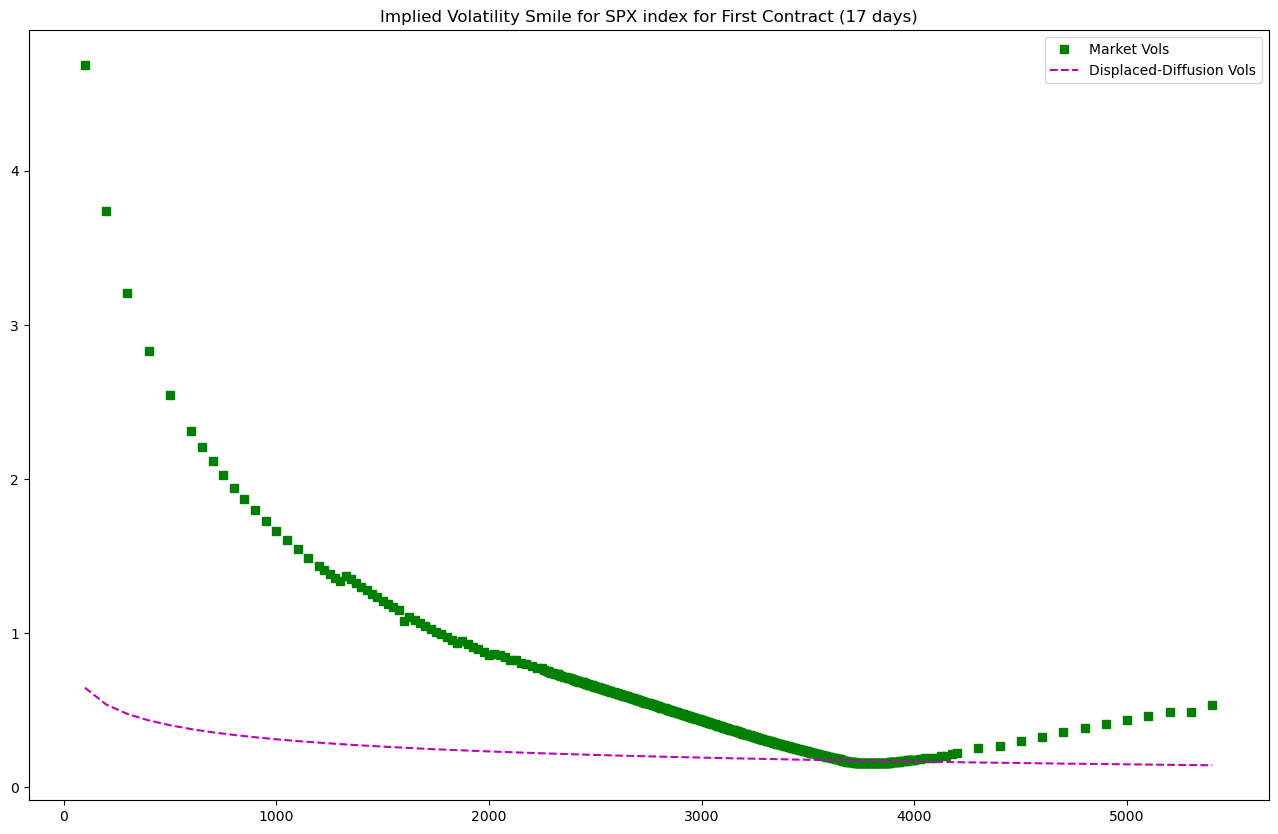

In [8]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spx_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, ddvols, 'm--', label='Displaced-Diffusion Vols')
plt.title("Implied Volatility Smile for SPX index for First Contract (17 days)")
plt.legend()
plt.show()

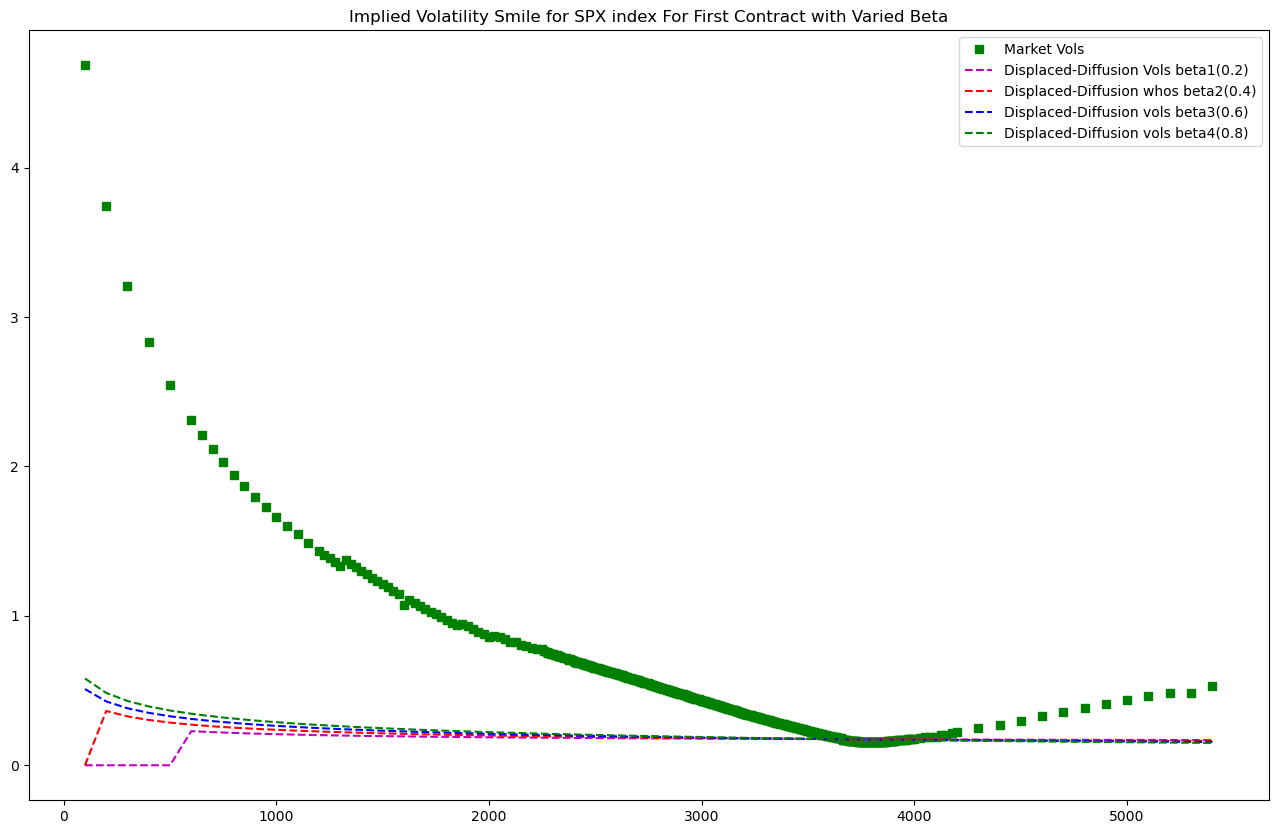

In [9]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spx_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(dd_df1['Strike'], dd_df1['impliedvol_beta1'], 'm--', label='Displaced-Diffusion Vols beta1(0.2)')
plt.plot(dd_df1['Strike'], dd_df1['impliedvol_beta2'], 'r--', label = 'Displaced-Diffusion whos beta2(0.4)')
plt.plot(dd_df1['Strike'], dd_df1['impliedvol_beta3'], 'b--', label = 'Displaced-Diffusion vols beta3(0.6)')
plt.plot(dd_df1['Strike'], dd_df1['impliedvol_beta4'], 'g--', label = 'Displaced-Diffusion vols beta4(0.8)')
plt.title("Implied Volatility Smile for SPX index For First Contract with Varied Beta")
plt.legend()
plt.show()

## Displaced-Diffusion Model with SPX Second Contract

In [10]:
spx_df = pd.read_csv('SPX_options.csv')
rate_df = pd.read_csv('zero_rates_20201201.csv')
spx_df['mid'] = 0.5*(spx_df['best_bid'] + spx_df['best_offer'])
spx_df['strike'] = spx_df['strike_price']*0.001
spx_df['payoff'] = spx_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(spx_df['exdate'].unique())[1]
spx_df = spx_df[spx_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
y = rate_df['days']
z = rate_df['rate']
f = interpolate.interp1d(y, z)
T = days_to_expiry/365
S = 3662.45
r = f(T * 365)/100.0
F = S*np.exp(r*T)

spx_df['vols'] = spx_df.apply(lambda x: impliedVolatility(S,
                                                x['strike'],
                                                r,
                                                x['mid'],
                                                T,
                                                x['payoff']),
                    axis=1)
spx_df.dropna(inplace=True)
call_df = spx_df[spx_df['payoff'] == 'call']
put_df = spx_df[spx_df['payoff'] == 'put']
strikes = put_df['strike'].values

call_atm1 = call_df[call_df['strike'] >= F]['mid'].iloc[0]
call_atm2 = call_df[call_df['strike'] <= F]['mid'].iloc[-1]
call_atm = (call_atm1 + call_atm2) / 2

put_atm1 = put_df[put_df['strike'] >= F]['mid'].iloc[0]
put_atm2 = put_df[put_df['strike'] <= F]['mid'].iloc[-1]
put_atm = (put_atm1 + put_atm2) / 2

call_sigma = impliedVolatility(S, F, r, call_atm, T, 'CALL')
put_sigma = impliedVolatility(S, F, r, put_atm, T, 'PUT')
sigma = (call_sigma + put_sigma) / 2

impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
spx_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})
    
initialGuess = [0.3]
res = least_squares(lambda x: ddcalibration(x, 
                                            S,
                                            spx_df['strike'],
                                            r,
                                            spx_df['impliedvol'],
                                            T),
                    initialGuess,
                    bounds = (0,1))
beta_dd = res.x[0]
print('Calibrated DD model parameters: beta_dd = %.5f' % (beta_dd))
ddvols = []
for K in strikes:
        price_dd = DisplacedDiffusion(S, K, r, sigma, T, beta_dd)
        volatility_dd = impliedVolatility2(S, K, r, price_dd, T)
        ddvols.append(volatility_dd)

Calibrated DD model parameters: beta_dd = 0.00000


In [11]:
sigma

0.18484183420567088

In [12]:
beta1 = 0.8
beta2 = 0.6
beta3 = 0.4
beta4 = 0.2

call_df = call_df.reset_index(drop=True)
put_df = put_df.reset_index(drop=True)

In [13]:
summarySPX_2 = []

for i in range(len(spx_df.index)):
    K = strikes[i]
    if K <= 3660:
        price_dd1 = displacediffusionput(S, K, r, sigma, T, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r, price_dd1, T)
        
        price_dd2 = displacediffusionput(S, K, r, sigma, T, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r, price_dd2, T)
        
        price_dd3 = displacediffusionput(S, K, r, sigma, T, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r, price_dd3, T)
        
        price_dd4 = displacediffusionput(S, K, r, sigma, T, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r, price_dd4, T)
        
    elif K > 3660: 
        
        price_dd1 = displacediffusioncall(S, K, r, sigma, T, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r, price_dd1, T)
        
        price_dd2 = displacediffusioncall(S, K, r, sigma, T, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r, price_dd2, T)
        
        price_dd3 = displacediffusioncall(S, K, r, sigma, T, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r, price_dd3, T)
        
        price_dd4 = displacediffusioncall(S, K, r, sigma, T, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r, price_dd4, T)
        
    summarySPX_2.append([K, 
                        impliedvol_dd1, impliedvol_dd2, impliedvol_dd3, 
                        impliedvol_dd4])
    
dd_df2 = pd.DataFrame(summarySPX_2, 
                      columns = ['Strike', 
                                'impliedvol_beta1', 
                                'impliedvol_beta2', 
                                'impliedvol_beta3', 
                                'impliedvol_beta4'])

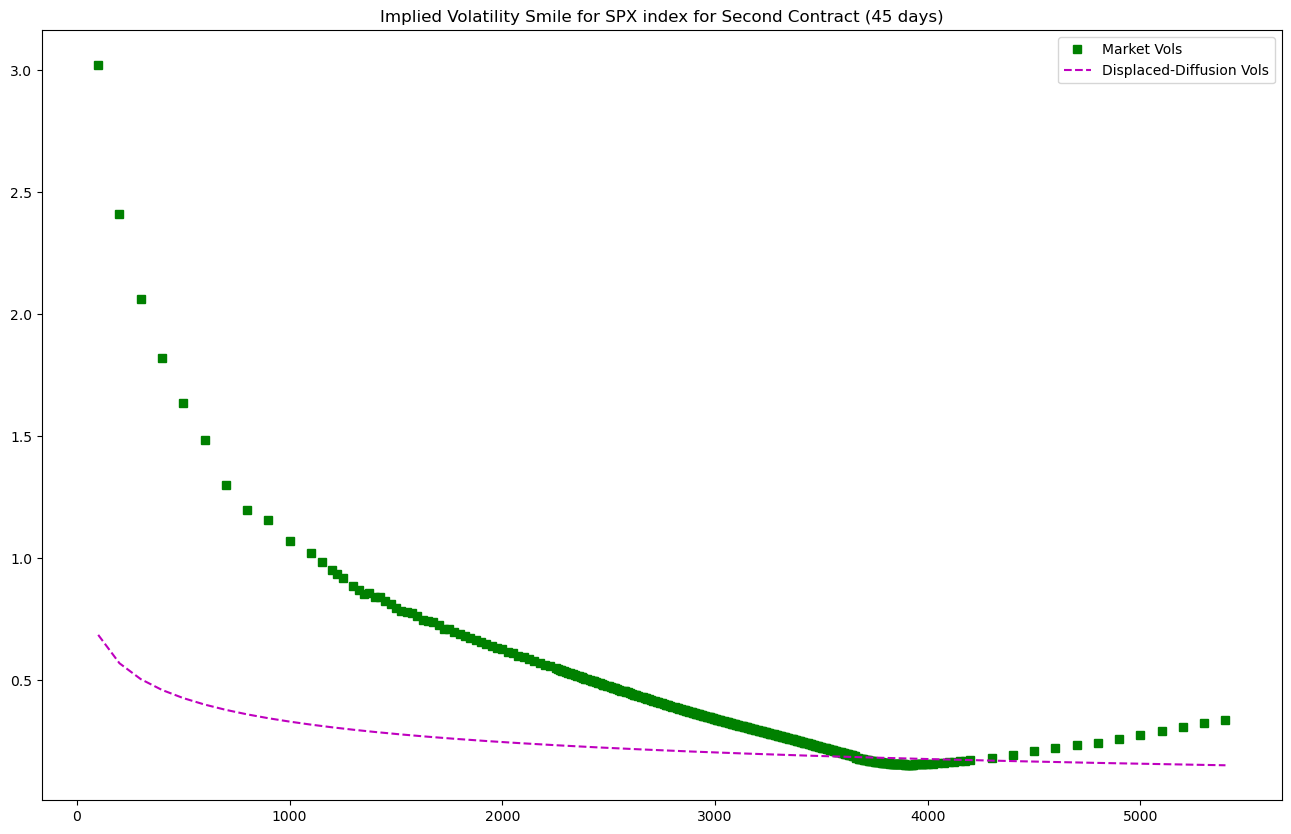

In [14]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spx_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, ddvols, 'm--', label='Displaced-Diffusion Vols')
plt.title("Implied Volatility Smile for SPX index for Second Contract (45 days)")
plt.legend()
plt.show()

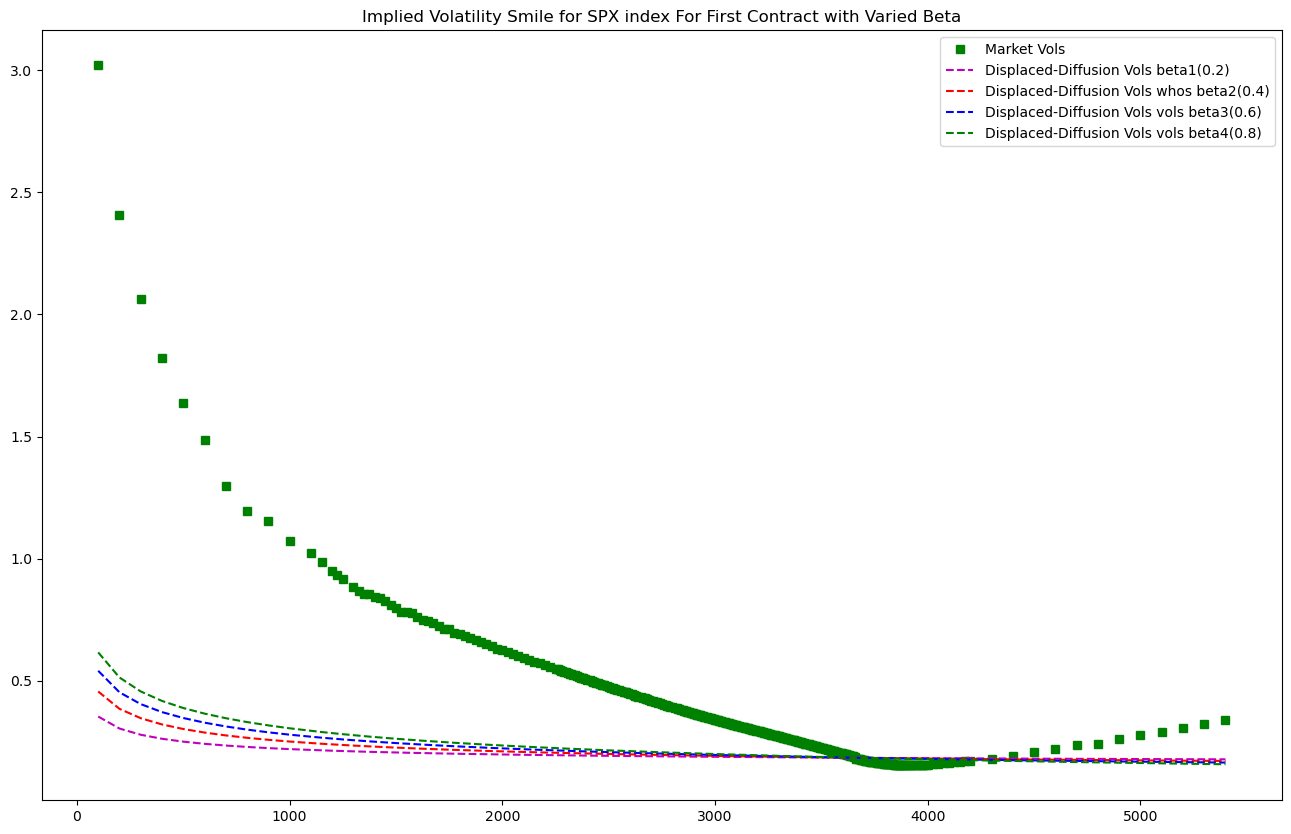

In [15]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spx_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(dd_df2['Strike'], dd_df2['impliedvol_beta1'], 'm--', label='Displaced-Diffusion Vols beta1(0.2)')
plt.plot(dd_df2['Strike'], dd_df2['impliedvol_beta2'], 'r--', label = 'Displaced-Diffusion Vols whos beta2(0.4)')
plt.plot(dd_df2['Strike'], dd_df2['impliedvol_beta3'], 'b--', label = 'Displaced-Diffusion Vols vols beta3(0.6)')
plt.plot(dd_df2['Strike'], dd_df2['impliedvol_beta4'], 'g--', label = 'Displaced-Diffusion Vols vols beta4(0.8)')
plt.title("Implied Volatility Smile for SPX index For Second Contract with Varied Beta")
plt.legend()
plt.show()

## Displaced-Diffusion Model with SPX Third Contract

In [16]:
spx_df = pd.read_csv('SPX_options.csv')
rate_df = pd.read_csv('zero_rates_20201201.csv')
spx_df['mid'] = 0.5*(spx_df['best_bid'] + spx_df['best_offer'])
spx_df['strike'] = spx_df['strike_price']*0.001
spx_df['payoff'] = spx_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(spx_df['exdate'].unique())[2]
spx_df = spx_df[spx_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
y = rate_df['days']
z = rate_df['rate']
f = interpolate.interp1d(y, z)
T = days_to_expiry/365
S = 3662.45
r = f(T * 365)/100.0
F = S*np.exp(r*T)

spx_df['vols'] = spx_df.apply(lambda x: impliedVolatility(S,
                                                x['strike'],
                                                r,
                                                x['mid'],
                                                T,
                                                x['payoff']),
                    axis=1)
spx_df.dropna(inplace=True)
call_df = spx_df[spx_df['payoff'] == 'call']
put_df = spx_df[spx_df['payoff'] == 'put']
strikes = put_df['strike'].values

call_atm1 = call_df[call_df['strike'] >= F]['mid'].iloc[0]
call_atm2 = call_df[call_df['strike'] <= F]['mid'].iloc[-1]
call_atm = (call_atm1 + call_atm2) / 2

put_atm1 = put_df[put_df['strike'] >= F]['mid'].iloc[0]
put_atm2 = put_df[put_df['strike'] <= F]['mid'].iloc[-1]
put_atm = (put_atm1 + put_atm2) / 2

call_sigma = impliedVolatility(S, F, r, call_atm, T, 'CALL')
put_sigma = impliedVolatility(S, F, r, put_atm, T, 'PUT')
sigma = (call_sigma + put_sigma) / 2

impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
spx_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})
    
initialGuess = [0.3]
res = least_squares(lambda x: ddcalibration(x, 
                                            S,
                                            spx_df['strike'],
                                            r,
                                            spx_df['impliedvol'],
                                            T),
                    initialGuess,
                    bounds = (0,1))
beta_dd = res.x[0]
print('Calibrated DD model parameters: beta_dd = %.5f' % (beta_dd))
ddvols= []
for K in strikes:
        price_dd = DisplacedDiffusion(S, K, r, sigma, T, beta_dd)
        volatility_dd = impliedVolatility2(S, K, r, price_dd, T)
        ddvols.append(volatility_dd)

Calibrated DD model parameters: beta_dd = 0.00000


In [17]:
sigma

0.1902205967628149

In [18]:
beta1 = 0.8
beta2 = 0.6
beta3 = 0.4
beta4 = 0.2

call_df = call_df.reset_index(drop=True)
put_df = put_df.reset_index(drop=True)

In [19]:
summarySPX_3 = []

for i in range(len(spx_df.index)):
    K = strikes[i]
    if K <= 3660:
        price_dd1 = displacediffusionput(S, K, r, sigma, T, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r, price_dd1, T)
        
        price_dd2 = displacediffusionput(S, K, r, sigma, T, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r, price_dd2, T)
        
        price_dd3 = displacediffusionput(S, K, r, sigma, T, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r, price_dd3, T)
        
        price_dd4 = displacediffusionput(S, K, r, sigma, T, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r, price_dd4, T)
        
    elif K > 3660: 
        
        price_dd1 = displacediffusioncall(S, K, r, sigma, T, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r, price_dd1, T)
        
        price_dd2 = displacediffusioncall(S, K, r, sigma, T, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r, price_dd2, T)
        
        price_dd3 = displacediffusioncall(S, K, r, sigma, T, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r, price_dd3, T)
        
        price_dd4 = displacediffusioncall(S, K, r, sigma, T, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r, price_dd4, T)
        
    summarySPX_3.append([K, 
                        impliedvol_dd1, impliedvol_dd2, impliedvol_dd3, 
                        impliedvol_dd4])
    
dd_df3 = pd.DataFrame(summarySPX_3, 
                      columns = ['Strike', 
                                'impliedvol_beta1', 
                                'impliedvol_beta2', 
                                'impliedvol_beta3', 
                                'impliedvol_beta4'])

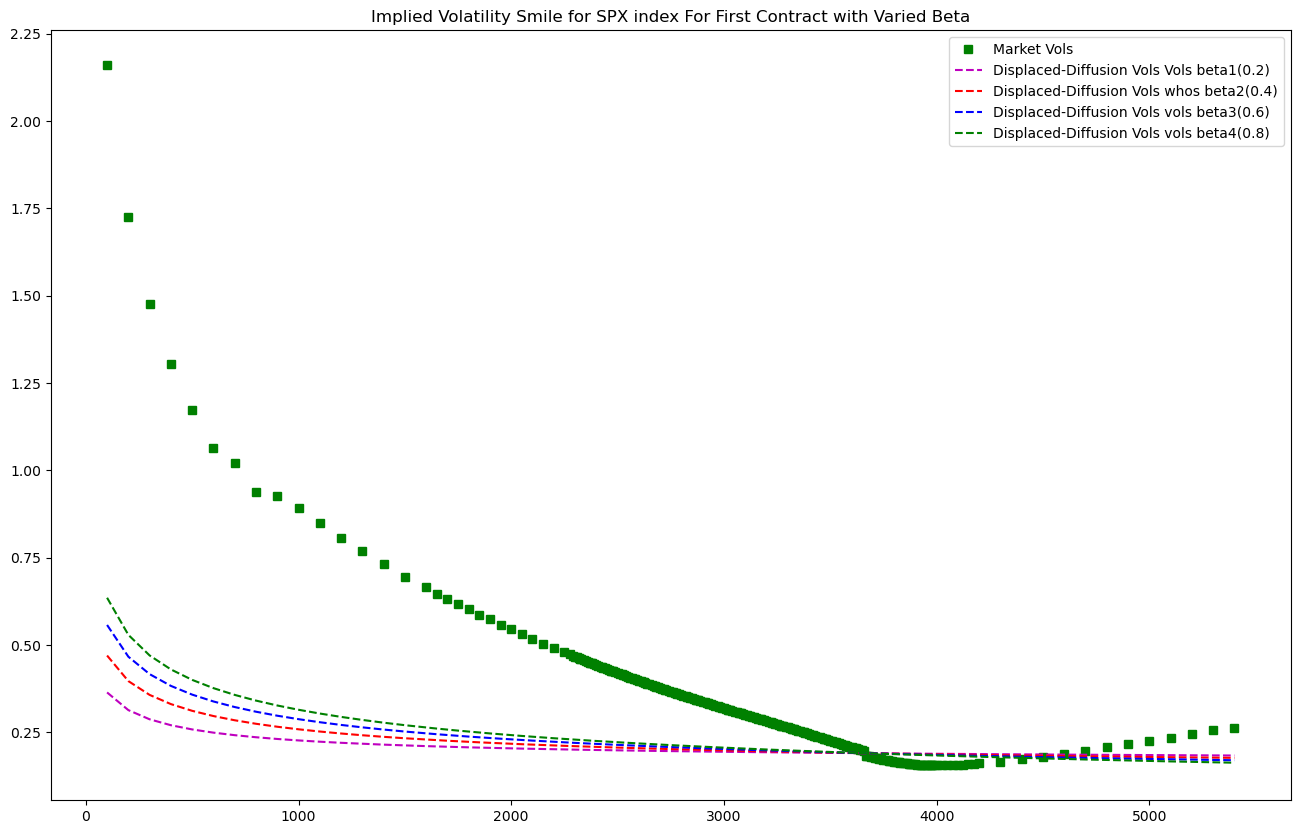

In [22]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spx_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(dd_df3['Strike'], dd_df3['impliedvol_beta1'], 'm--', label='Displaced-Diffusion Vols Vols beta1(0.2)')
plt.plot(dd_df3['Strike'], dd_df3['impliedvol_beta2'], 'r--', label = 'Displaced-Diffusion Vols whos beta2(0.4)')
plt.plot(dd_df3['Strike'], dd_df3['impliedvol_beta3'], 'b--', label = 'Displaced-Diffusion Vols vols beta3(0.6)')
plt.plot(dd_df3['Strike'], dd_df3['impliedvol_beta4'], 'g--', label = 'Displaced-Diffusion Vols vols beta4(0.8)')
plt.title("Implied Volatility Smile for SPX index For First Contract with Varied Beta")
plt.legend()
plt.show()

## Displaced-Diffusion Model with SPY First Contract

In [41]:
spy_df = pd.read_csv('SPY_options.csv')
spy_df['mid'] = 0.5*(spy_df['best_bid'] + spy_df['best_offer'])
spy_df['strike'] = spy_df['strike_price']*0.001
spy_df['payoff'] = spy_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(spy_df['exdate'].unique())[0]
spy_df = spy_df[spy_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
y = rate_df['days']
z = rate_df['rate']
f = interpolate.interp1d(y, z)
T = days_to_expiry/365
S = 366.02
r = f(T * 365)/100.0
F = S*np.exp(r*T)

spy_df['vols'] = spy_df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
spy_df.dropna(inplace=True)
call_df = spy_df[spy_df['payoff'] == 'call']
put_df = spy_df[spy_df['payoff'] == 'put']
strikes = put_df['strike'].values

call_atm1 = call_df[call_df['strike'] >= F]['mid'].iloc[0]
call_atm2 = call_df[call_df['strike'] <= F]['mid'].iloc[-1]
call_atm = (call_atm1 + call_atm2) / 2

put_atm1 = put_df[put_df['strike'] >= F]['mid'].iloc[0]
put_atm2 = put_df[put_df['strike'] <= F]['mid'].iloc[-1]
put_atm = (put_atm1 + put_atm2) / 2

call_sigma = impliedVolatility(S, F, r, call_atm, T, 'CALL')
put_sigma = impliedVolatility(S, F, r, put_atm, T, 'PUT')
sigma = (call_sigma + put_sigma) / 2

impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
spy_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.3]
res = least_squares(lambda x: ddcalibration(x, 
                                            S,
                                            spx_df['strike'],
                                            r,
                                            spx_df['impliedvol'],
                                            T),
                    initialGuess,
                    bounds = (0,1))
beta_dd = res.x[0]
print('Calibrated DD model parameters: beta_dd = %.5f' % (beta_dd))
ddvols = []
for K in strikes:
        price_dd = DisplacedDiffusion(S, K, r, sigma, T, beta_dd)
        volatility_dd = impliedVolatility2(S, K, r, price_dd, T)
        ddvols.append(volatility_dd)

Calibrated DD model parameters: beta_dd = 0.17732


In [42]:
sigma

0.18612537494778245

In [43]:
beta1 = 0.8
beta2 = 0.6
beta3 = 0.4
beta4 = 0.2

call_df = call_df.reset_index(drop=True)
put_df = put_df.reset_index(drop=True)

In [44]:
summarySPY_1 = []

for i in range(len(spy_df.index)):
    K = strikes[i]
    if K <= 367:
        price_dd1 = displacediffusionput(S, K, r, sigma, T, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r, price_dd1, T)
        
        price_dd2 = displacediffusionput(S, K, r, sigma, T, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r, price_dd2, T)
        
        price_dd3 = displacediffusionput(S, K, r, sigma, T, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r, price_dd3, T)
        
        price_dd4 = displacediffusionput(S, K, r, sigma, T, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r, price_dd4, T)
        
    elif K > 367: 
        
        price_dd1 = displacediffusioncall(S, K, r, sigma, T, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r, price_dd1, T)
        
        price_dd2 = displacediffusioncall(S, K, r, sigma, T, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r, price_dd2, T)
        
        price_dd3 = displacediffusioncall(S, K, r, sigma, T, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r, price_dd3, T)
        
        price_dd4 = displacediffusioncall(S, K, r, sigma, T, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r, price_dd4, T)
        
    summarySPY_1.append([K, 
                        impliedvol_dd1, impliedvol_dd2, impliedvol_dd3, 
                        impliedvol_dd4])
    
dd_df1 = pd.DataFrame(summarySPY_1, 
                      columns = ['Strike', 
                                'impliedvol_beta1', 
                                'impliedvol_beta2', 
                                'impliedvol_beta3', 
                                'impliedvol_beta4'])

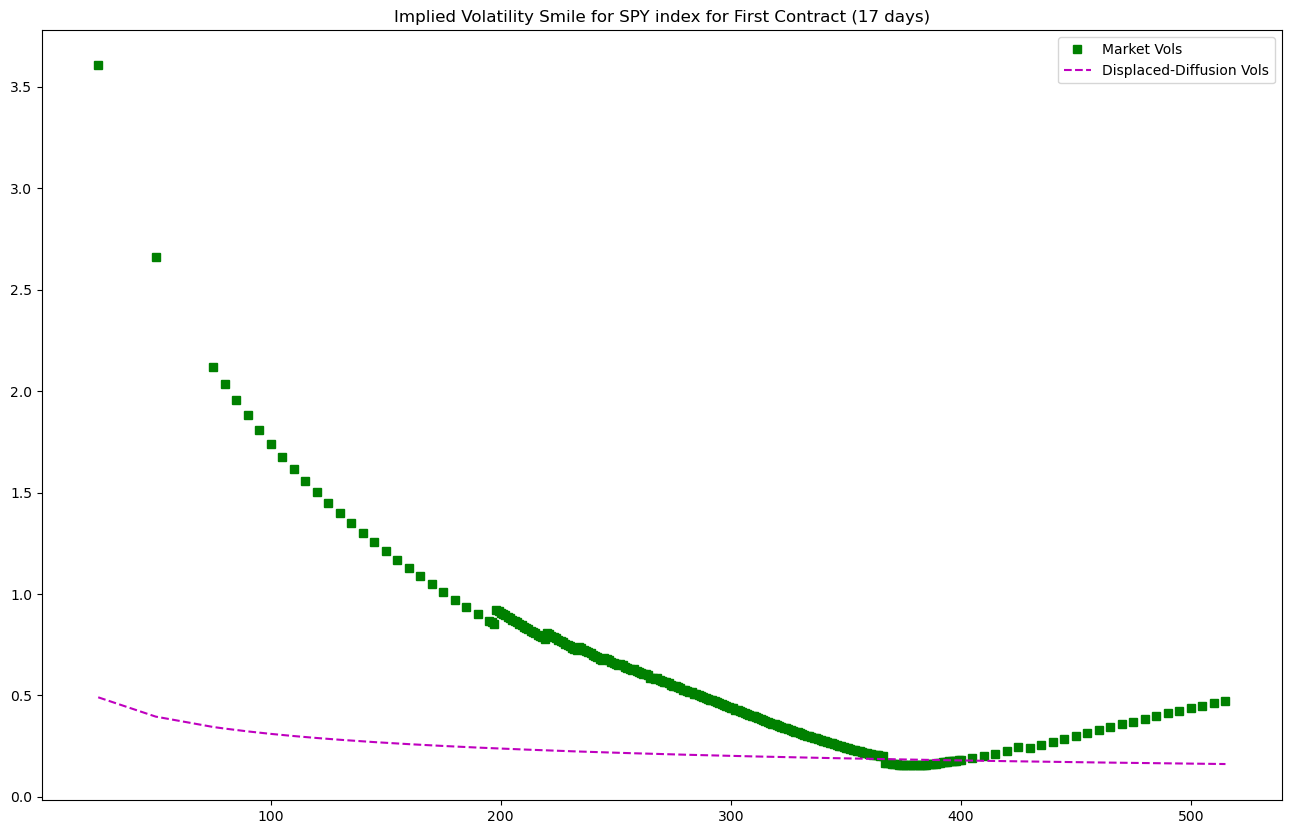

In [45]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spy_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, ddvols, 'm--', label='Displaced-Diffusion Vols')
plt.title("Implied Volatility Smile for SPY index for First Contract (17 days)")
plt.legend()
plt.show()

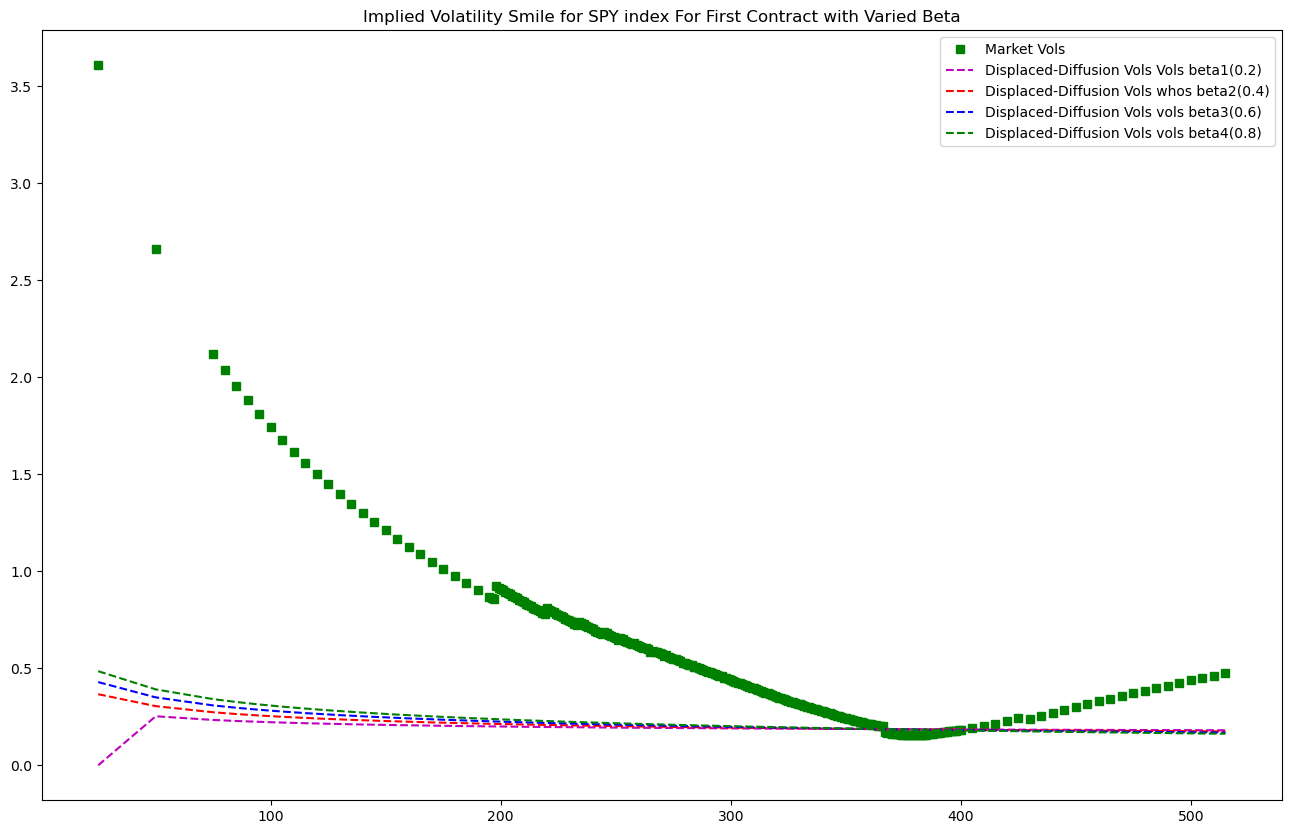

In [46]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spy_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(dd_df1['Strike'], dd_df1['impliedvol_beta1'], 'm--', label='Displaced-Diffusion Vols Vols beta1(0.2)')
plt.plot(dd_df1['Strike'], dd_df1['impliedvol_beta2'], 'r--', label = 'Displaced-Diffusion Vols whos beta2(0.4)')
plt.plot(dd_df1['Strike'], dd_df1['impliedvol_beta3'], 'b--', label = 'Displaced-Diffusion Vols vols beta3(0.6)')
plt.plot(dd_df1['Strike'], dd_df1['impliedvol_beta4'], 'g--', label = 'Displaced-Diffusion Vols vols beta4(0.8)')
plt.title("Implied Volatility Smile for SPY index For First Contract with Varied Beta")
plt.legend()
plt.show()

## Displaced-Diffusion Model with SPY Second Contract

In [47]:
spy_df = pd.read_csv('SPY_options.csv')
spy_df['mid'] = 0.5*(spy_df['best_bid'] + spy_df['best_offer'])
spy_df['strike'] = spy_df['strike_price']*0.001
spy_df['payoff'] = spy_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(spy_df['exdate'].unique())[1]
spy_df = spy_df[spy_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
y = rate_df['days']
z = rate_df['rate']
f = interpolate.interp1d(y, z)
T = days_to_expiry/365
S = 366.02
r = f(T * 365)/100.0
F = S*np.exp(r*T)

spy_df['vols'] = spy_df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
spy_df.dropna(inplace=True)
call_df = spy_df[spy_df['payoff'] == 'call']
put_df = spy_df[spy_df['payoff'] == 'put']
strikes = put_df['strike'].values


call_atm1 = call_df[call_df['strike'] >= F]['mid'].iloc[0]
call_atm2 = call_df[call_df['strike'] <= F]['mid'].iloc[-1]
call_atm = (call_atm1 + call_atm2) / 2

put_atm1 = put_df[put_df['strike'] >= F]['mid'].iloc[0]
put_atm2 = put_df[put_df['strike'] <= F]['mid'].iloc[-1]
put_atm = (put_atm1 + put_atm2) / 2

call_sigma = impliedVolatility(S, F, r, call_atm, T, 'CALL')
put_sigma = impliedVolatility(S, F, r, put_atm, T, 'PUT')
sigma = (call_sigma + put_sigma) / 2

impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
spy_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.3]
res = least_squares(lambda x: ddcalibration(x, 
                                            S,
                                            spx_df['strike'],
                                            r,
                                            spx_df['impliedvol'],
                                            T),
                    initialGuess,
                    bounds = (0,1))
beta_dd = res.x[0]
print('Calibrated DD model parameters: beta_dd = %.5f' % (beta_dd))
ddvols = []
for K in strikes:
        price_dd = DisplacedDiffusion(S, K, r, sigma, T, beta_dd)
        volatility_dd = impliedVolatility2(S, K, r, price_dd, T)
        ddvols.append(volatility_dd)

Calibrated DD model parameters: beta_dd = 1.00000


In [48]:
sigma

0.18422449050114165

In [49]:
beta1 = 0.8
beta2 = 0.6
beta3 = 0.4
beta4 = 0.2

call_df = call_df.reset_index(drop=True)
put_df = put_df.reset_index(drop=True)

In [50]:
summarySPY_2 = []

for i in range(len(spy_df.index)):
    K = strikes[i]
    if K <= 367:
        price_dd1 = displacediffusionput(S, K, r, sigma, T, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r, price_dd1, T)
        
        price_dd2 = displacediffusionput(S, K, r, sigma, T, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r, price_dd2, T)
        
        price_dd3 = displacediffusionput(S, K, r, sigma, T, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r, price_dd3, T)
        
        price_dd4 = displacediffusionput(S, K, r, sigma, T, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r, price_dd4, T)
        
    elif K > 367: 
        
        price_dd1 = displacediffusioncall(S, K, r, sigma, T, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r, price_dd1, T)
        
        price_dd2 = displacediffusioncall(S, K, r, sigma, T, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r, price_dd2, T)
        
        price_dd3 = displacediffusioncall(S, K, r, sigma, T, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r, price_dd3, T)
        
        price_dd4 = displacediffusioncall(S, K, r, sigma, T, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r, price_dd4, T)
        
    summarySPY_2.append([K, 
                        impliedvol_dd1, impliedvol_dd2, impliedvol_dd3, 
                        impliedvol_dd4])
    
dd_df2 = pd.DataFrame(summarySPY_2, 
                      columns = ['Strike', 
                                'impliedvol_beta1', 
                                'impliedvol_beta2', 
                                'impliedvol_beta3', 
                                'impliedvol_beta4'])

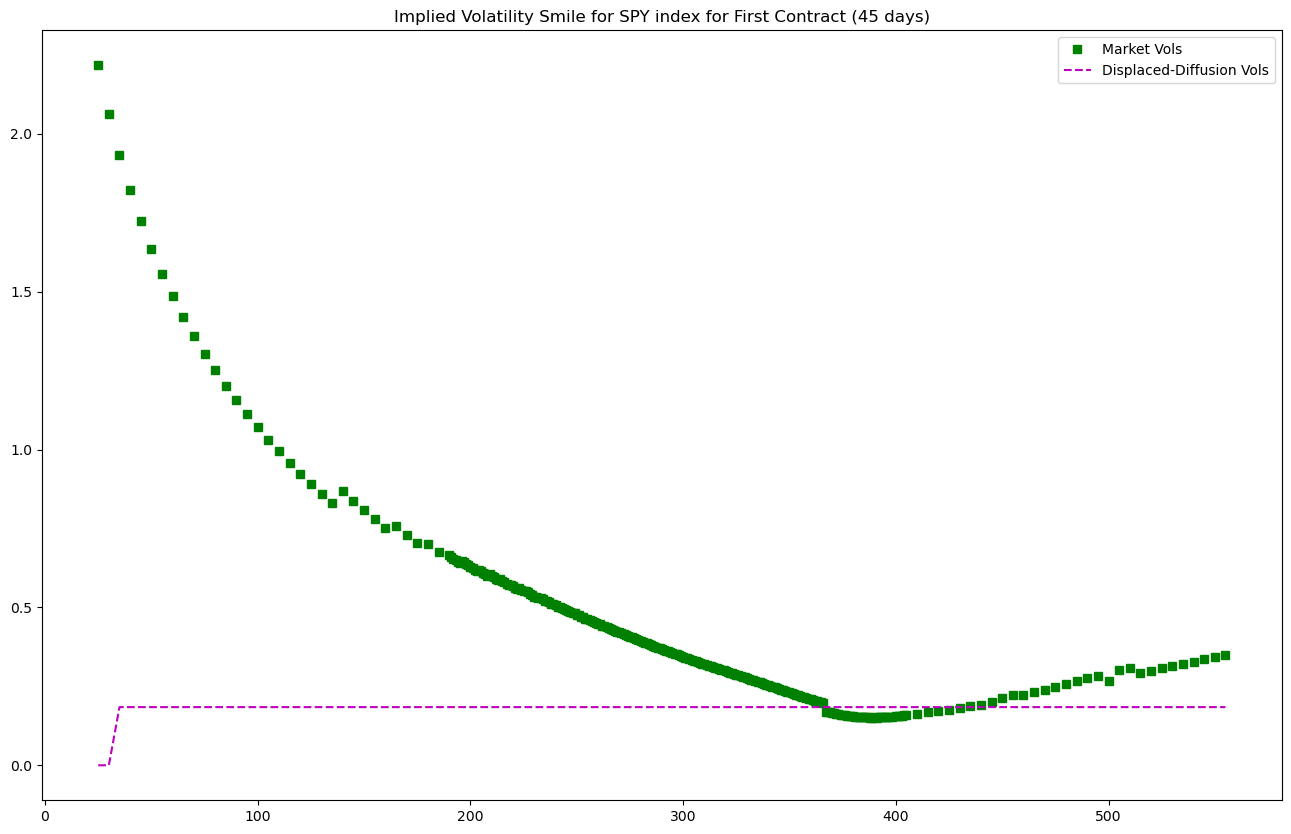

In [51]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spy_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, ddvols, 'm--', label='Displaced-Diffusion Vols')
plt.title("Implied Volatility Smile for SPY index for Second Contract (45 days)")
plt.legend()
plt.show()

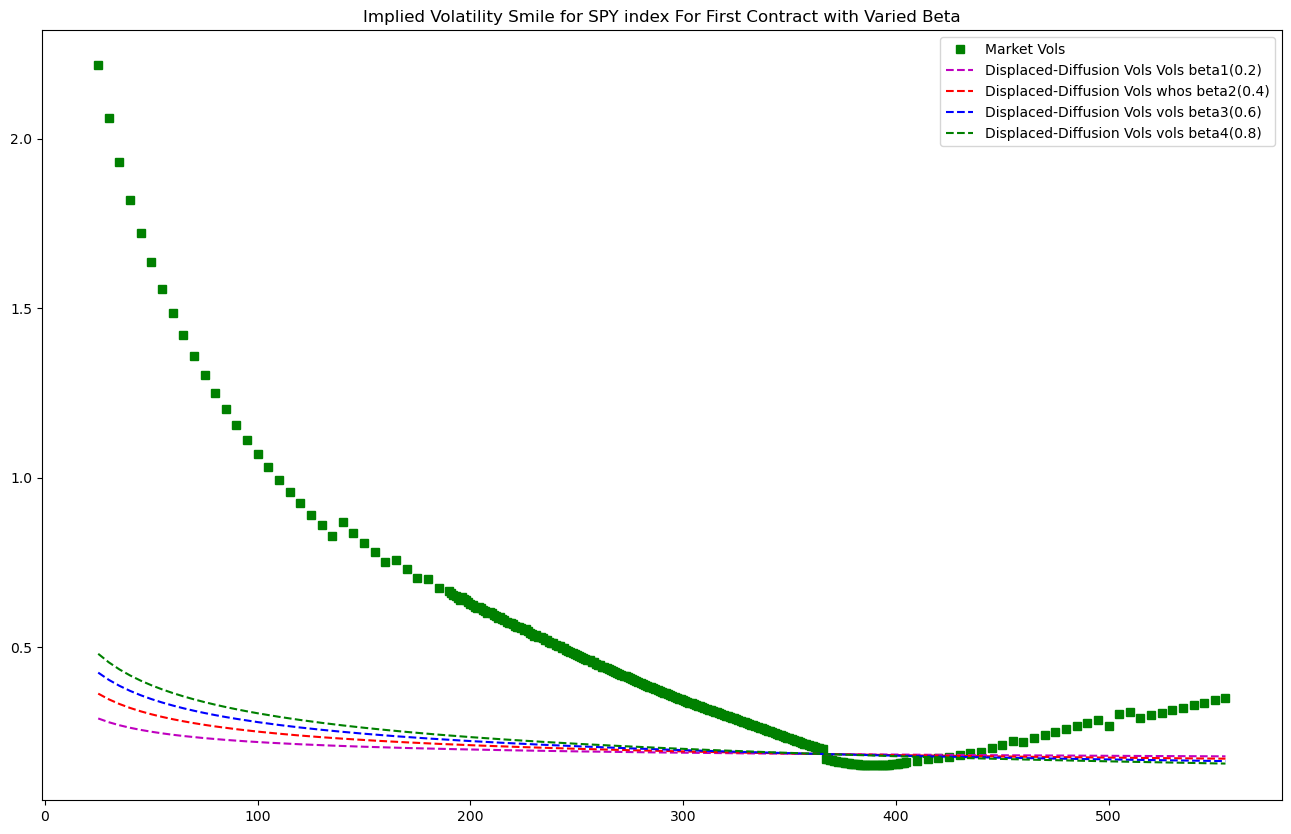

In [52]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spy_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(dd_df2['Strike'], dd_df2['impliedvol_beta1'], 'm--', label='Displaced-Diffusion Vols Vols beta1(0.2)')
plt.plot(dd_df2['Strike'], dd_df2['impliedvol_beta2'], 'r--', label = 'Displaced-Diffusion Vols whos beta2(0.4)')
plt.plot(dd_df2['Strike'], dd_df2['impliedvol_beta3'], 'b--', label = 'Displaced-Diffusion Vols vols beta3(0.6)')
plt.plot(dd_df2['Strike'], dd_df2['impliedvol_beta4'], 'g--', label = 'Displaced-Diffusion Vols vols beta4(0.8)')
plt.title("Implied Volatility Smile for SPY index For First Contract with Varied Beta")
plt.legend()
plt.show()

## Displaced-Diffusion Model with SPY Third Contract

In [53]:
spy_df = pd.read_csv('SPY_options.csv')
spy_df['mid'] = 0.5*(spy_df['best_bid'] + spy_df['best_offer'])
spy_df['strike'] = spy_df['strike_price']*0.001
spy_df['payoff'] = spy_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(spy_df['exdate'].unique())[2]
spy_df = spy_df[spy_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
y = rate_df['days']
z = rate_df['rate']
f = interpolate.interp1d(y, z)
T = days_to_expiry/365
S = 366.02
r = f(T * 365)/100.0
F = S*np.exp(r*T)

spy_df['vols'] = spy_df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
spy_df.dropna(inplace=True)
call_df = spy_df[spy_df['payoff'] == 'call']
put_df = spy_df[spy_df['payoff'] == 'put']
strikes = put_df['strike'].values

call_atm1 = call_df[call_df['strike'] >= F]['mid'].iloc[0]
call_atm2 = call_df[call_df['strike'] <= F]['mid'].iloc[-1]
call_atm = (call_atm1 + call_atm2) / 2

put_atm1 = put_df[put_df['strike'] >= F]['mid'].iloc[0]
put_atm2 = put_df[put_df['strike'] <= F]['mid'].iloc[-1]
put_atm = (put_atm1 + put_atm2) / 2

call_sigma = impliedVolatility(S, F, r, call_atm, T, 'CALL')
put_sigma = impliedVolatility(S, F, r, put_atm, T, 'PUT')
sigma = (call_sigma + put_sigma) / 2

impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
spy_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.3]
res = least_squares(lambda x: ddcalibration(x, 
                                            S,
                                            spx_df['strike'],
                                            r,
                                            spx_df['impliedvol'],
                                            T),
                    initialGuess,
                    bounds = (0,1))
beta_dd = res.x[0]
print('Calibrated DD model parameters: beta_dd = %.5f' % (beta_dd))
ddvols = []
for K in strikes:
        price_dd = DisplacedDiffusion(S, K, r, sigma, T, beta_dd)
        volatility_dd = impliedVolatility2(S, K, r, price_dd, T)
        ddvols.append(volatility_dd)

Calibrated DD model parameters: beta_dd = 1.00000


In [54]:
sigma

0.19044791215146556

In [55]:
beta1 = 0.8
beta2 = 0.6
beta3 = 0.4
beta4 = 0.2

call_df = call_df.reset_index(drop=True)
put_df = put_df.reset_index(drop=True)

In [56]:
summarySPY_3 = []

for i in range(len(spy_df.index)):
    K = strikes[i]
    if K <= 367:
        price_dd1 = displacediffusionput(S, K, r, sigma, T, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r, price_dd1, T)
        
        price_dd2 = displacediffusionput(S, K, r, sigma, T, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r, price_dd2, T)
        
        price_dd3 = displacediffusionput(S, K, r, sigma, T, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r, price_dd3, T)
        
        price_dd4 = displacediffusionput(S, K, r, sigma, T, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r, price_dd4, T)
        
    elif K > 367: 
        
        price_dd1 = displacediffusioncall(S, K, r, sigma, T, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r, price_dd1, T)
        
        price_dd2 = displacediffusioncall(S, K, r, sigma, T, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r, price_dd2, T)
        
        price_dd3 = displacediffusioncall(S, K, r, sigma, T, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r, price_dd3, T)
        
        price_dd4 = displacediffusioncall(S, K, r, sigma, T, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r, price_dd4, T)
        
    summarySPY_3.append([K, 
                        impliedvol_dd1, impliedvol_dd2, impliedvol_dd3, 
                        impliedvol_dd4])
    
dd_df3 = pd.DataFrame(summarySPY_3, 
                      columns = ['Strike', 
                                'impliedvol_beta1', 
                                'impliedvol_beta2', 
                                'impliedvol_beta3', 
                                'impliedvol_beta4'])

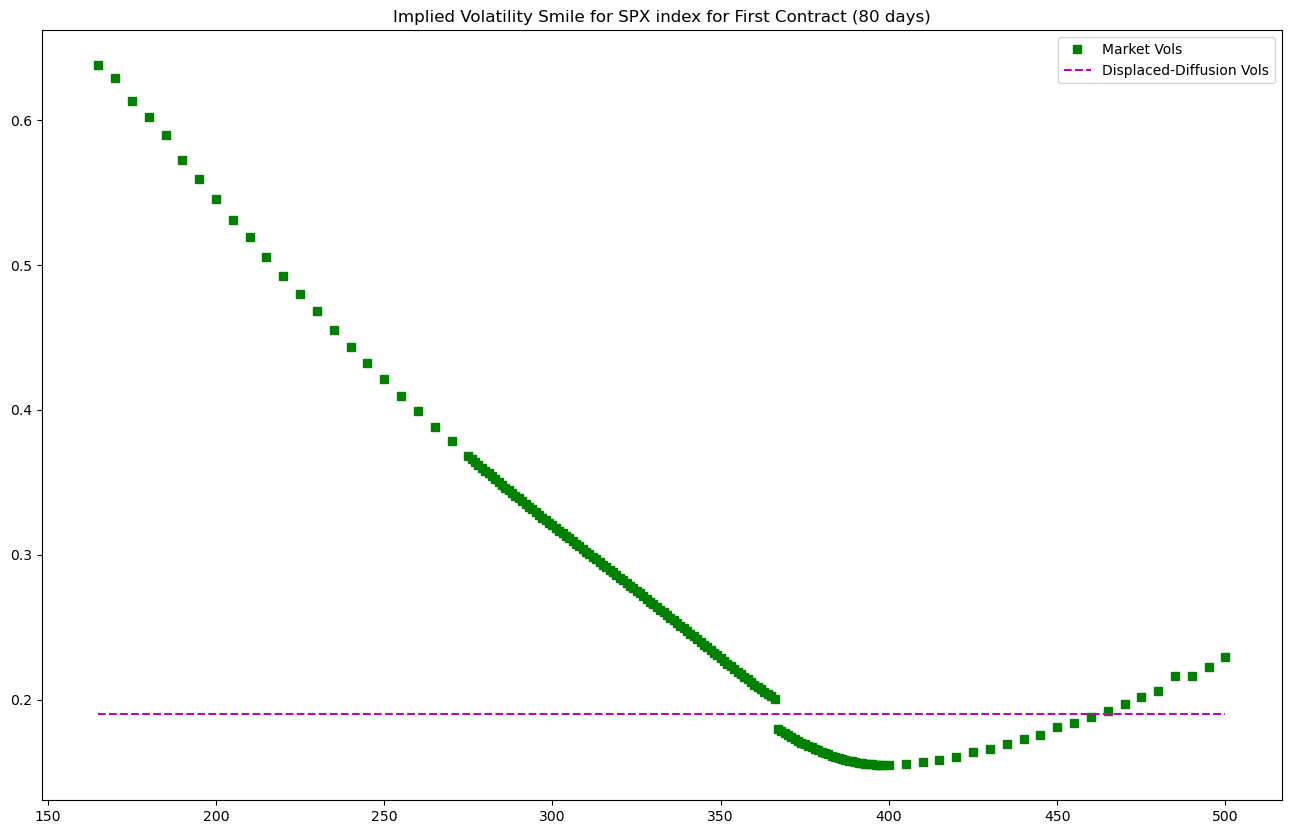

In [57]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spy_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, ddvols, 'm--', label='Displaced-Diffusion Vols')
plt.title("Implied Volatility Smile for SPX index for First Contract (80 days)")
plt.legend()
plt.show()

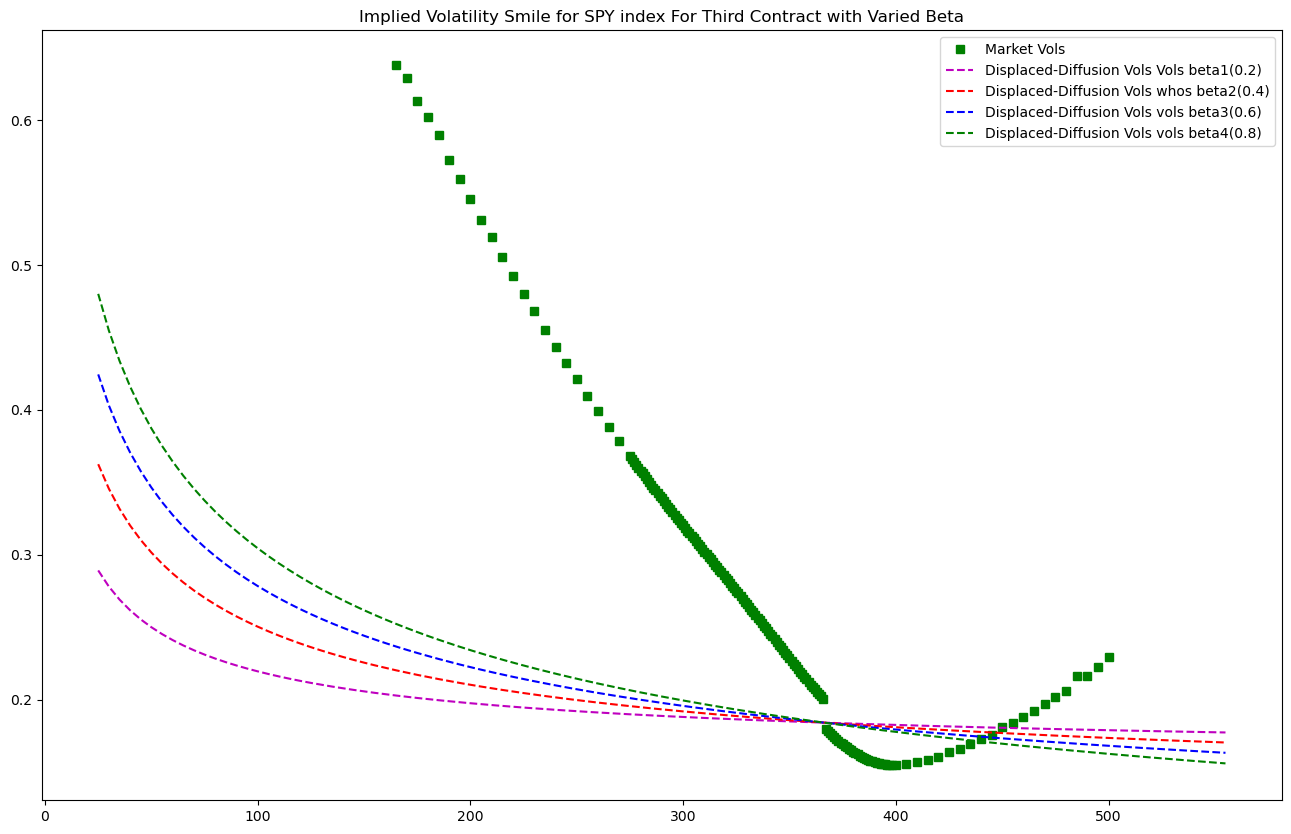

In [58]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spy_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(dd_df2['Strike'], dd_df2['impliedvol_beta1'], 'm--', label='Displaced-Diffusion Vols Vols beta1(0.2)')
plt.plot(dd_df2['Strike'], dd_df2['impliedvol_beta2'], 'r--', label = 'Displaced-Diffusion Vols whos beta2(0.4)')
plt.plot(dd_df2['Strike'], dd_df2['impliedvol_beta3'], 'b--', label = 'Displaced-Diffusion Vols vols beta3(0.6)')
plt.plot(dd_df2['Strike'], dd_df2['impliedvol_beta4'], 'g--', label = 'Displaced-Diffusion Vols vols beta4(0.8)')
plt.title("Implied Volatility Smile for SPY index For Third Contract with Varied Beta")
plt.legend()
plt.show()

## SABR Model ( fixed $\beta$ = 0.7)

In [59]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [60]:
from scipy.optimize import least_squares

beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err


def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                blackscholescall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                blackscholesput(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

def blackscholescall(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + (sigma ** 2 / 2)) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    V = S * norm.cdf(d1) - K * np.exp(-r * T)* norm.cdf(d2)
    return V


def blackscholesput(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + (sigma ** 2  / 2)) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    V = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return V

### SABR Model SPX Index With First Contract

In [61]:
spx_df = pd.read_csv('SPX_options.csv')
rate_df = pd.read_csv('zero_rates_20201201.csv')
spx_df['mid'] = 0.5*(spx_df['best_bid'] + spx_df['best_offer'])
spx_df['strike'] = spx_df['strike_price']*0.001
spx_df['payoff'] = spx_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(spx_df['exdate'].unique())[0]
spx_df = spx_df[spx_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
y = rate_df['days']
z = rate_df['rate']
f = interpolate.interp1d(y, z)
T = days_to_expiry/365
S = 3662.45
r = f(T * 365)/100.0
F = S*np.exp(r*T)

spx_df['vols'] = spx_df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
spx_df.dropna(inplace=True)
call_df = spx_df[spx_df['payoff'] == 'call']
put_df = spx_df[spx_df['payoff'] == 'put']
strikes = put_df['strike'].values
impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
spx_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              spx_df['strike'],
                                              spx_df['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 1.212, beta = 0.7, rho = -0.301, nu = 5.460


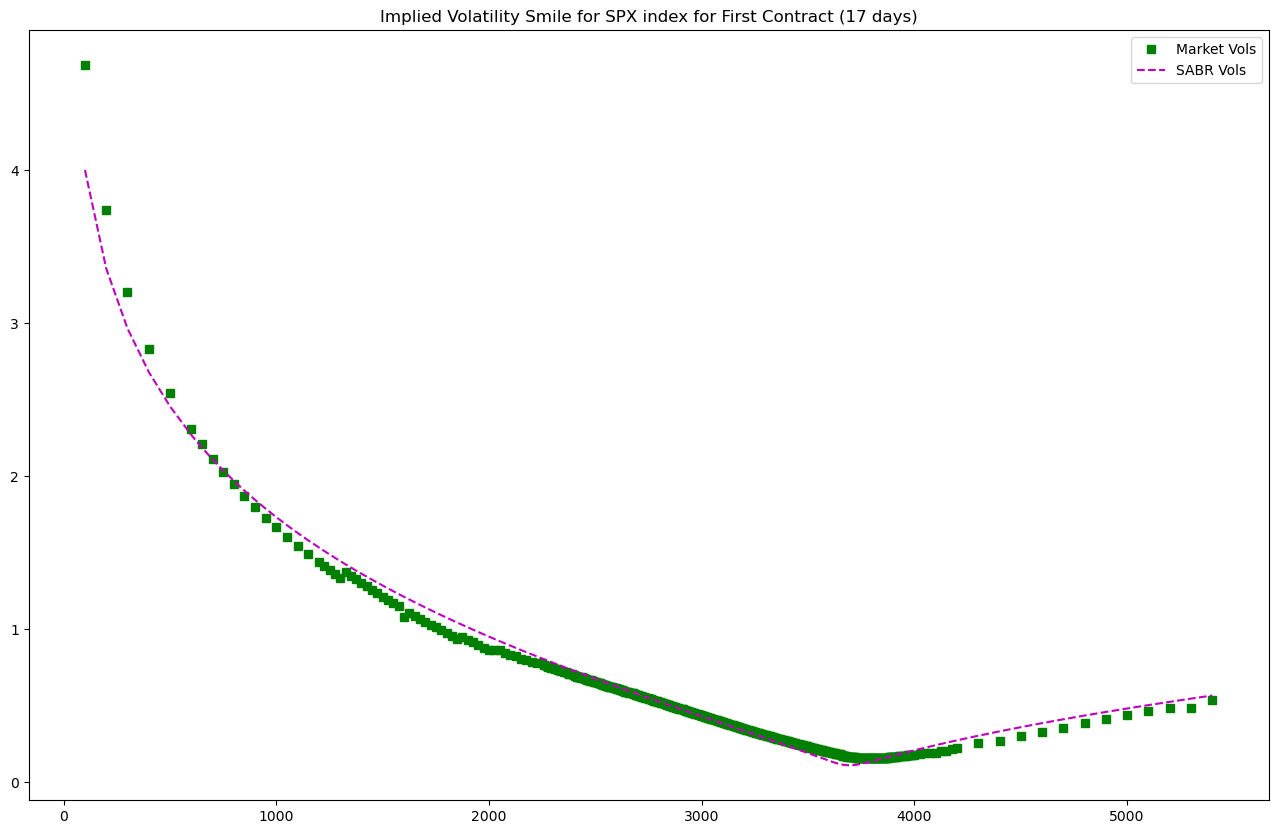

In [62]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spx_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.title("Implied Volatility Smile for SPX index for First Contract (17 days)")
plt.legend()
plt.show()

In [63]:
rho1 = -0.6
rho2 = 0
rho3 = 0.4

nu1 = 1
nu2 = 5
nu3 = 10

beta = 0.7

In [64]:
summary_SABR = []
for K in strikes:
    impliedvol_SABR = SABR(F, K, T, alpha, beta, rho, nu)
    impliedvol_rho1 = SABR(F, K, T, alpha, beta, rho1, nu)
    impliedvol_rho2 = SABR(F, K, T, alpha, beta, rho2, nu)
    impliedvol_rho3 = SABR(F, K, T, alpha, beta, rho3, nu)
    
    impliedvol_nu1 = SABR(F, K, T, alpha, beta, rho, nu1)
    impliedvol_nu2 = SABR(F, K, T, alpha, beta, rho, nu2)
    impliedvol_nu3 = SABR(F, K, T, alpha, beta, rho, nu3)
    summary_SABR.append([impliedvol_SABR, 
                        impliedvol_rho1, 
                        impliedvol_rho2, 
                        impliedvol_rho3, 
                        impliedvol_nu1, 
                        impliedvol_nu2,
                        impliedvol_nu3])

In [65]:
spx_SABR_df = pd.DataFrame(summary_SABR, 
                          columns = ['impliedvol_SABR', 
                                    'impliedvol_rho1', 
                                    'impliedvol_rho2', 
                                    'impliedvol_rho3', 
                                    'impliedvol_nu1', 
                                    'impliedvol_nu2', 'impliedvol_nu3'])

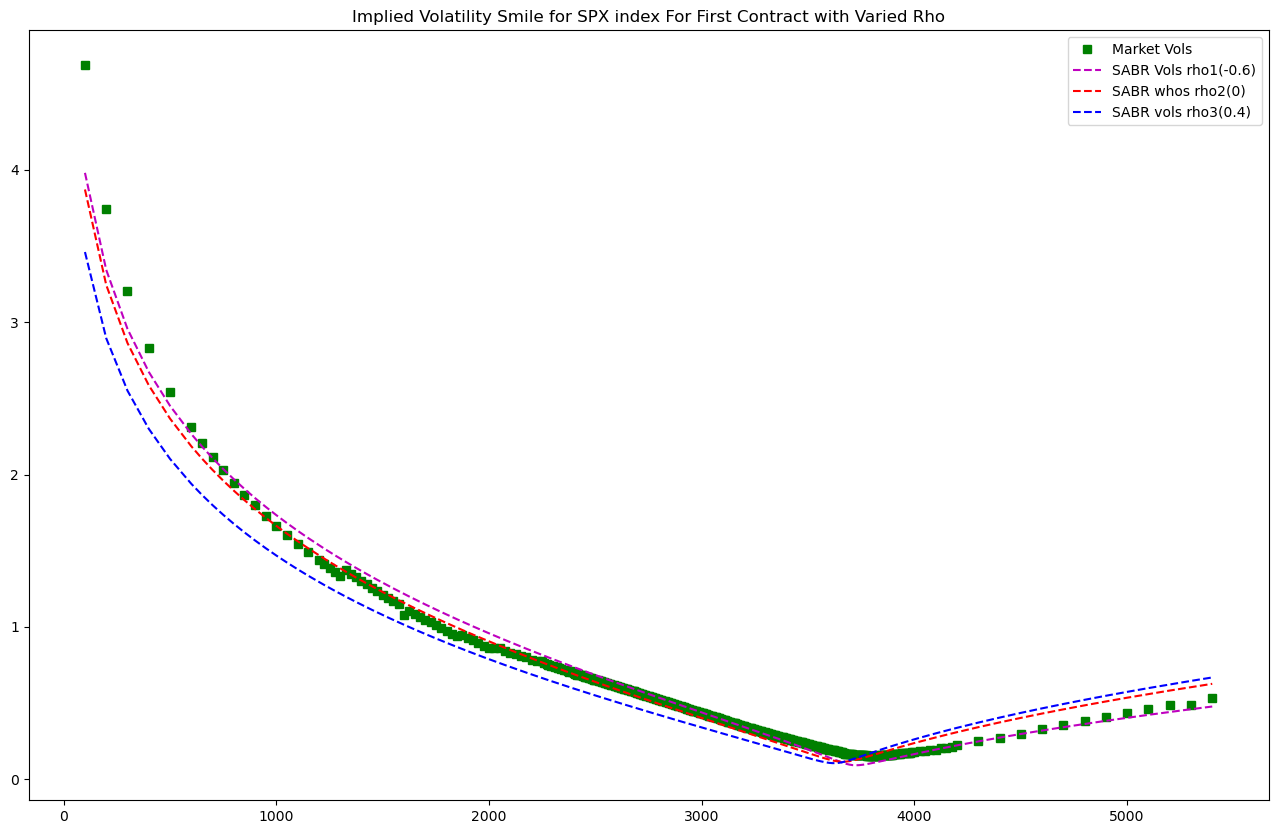

In [66]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spx_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, spx_SABR_df['impliedvol_rho1'], 'm--', label='SABR Vols rho1(-0.6)')
plt.plot(strikes, spx_SABR_df['impliedvol_rho2'], 'r--', label = 'SABR whos rho2(0)')
plt.plot(strikes, spx_SABR_df['impliedvol_rho3'], 'b--', label = 'SABR vols rho3(0.4)')
plt.title("Implied Volatility Smile for SPX index For First Contract with Varied Rho")
plt.legend()
plt.show()

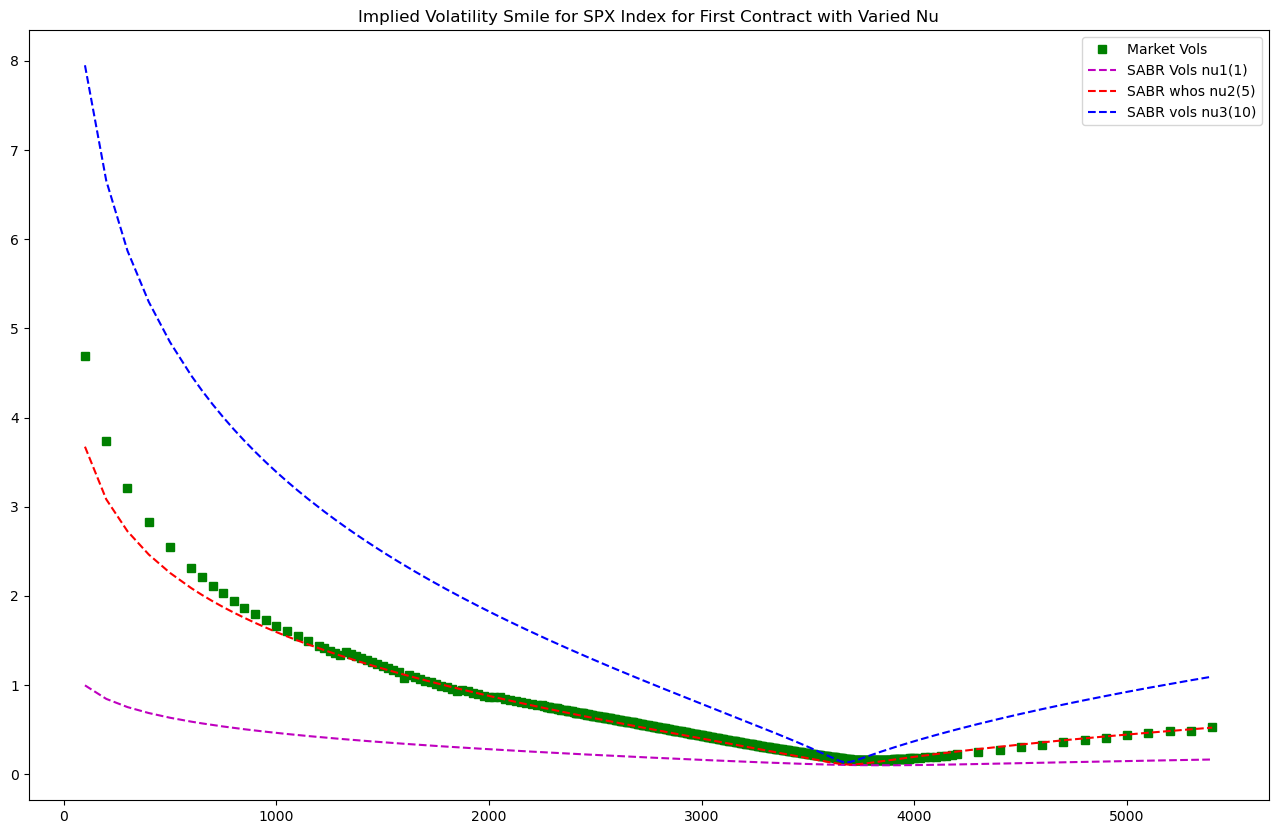

In [67]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spx_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, spx_SABR_df['impliedvol_nu1'], 'm--', label='SABR Vols nu1(1)')
plt.plot(strikes, spx_SABR_df['impliedvol_nu2'], 'r--', label = 'SABR whos nu2(5)')
plt.plot(strikes, spx_SABR_df['impliedvol_nu3'], 'b--', label = 'SABR vols nu3(10)')
plt.title("Implied Volatility Smile for SPX Index for First Contract with Varied Nu")
plt.legend()
plt.show()

### SABR Model SPX Index with Second Contract

In [68]:
spx_df = pd.read_csv('SPX_options.csv')
rate_df = pd.read_csv('zero_rates_20201201.csv')
spx_df['mid'] = 0.5*(spx_df['best_bid'] + spx_df['best_offer'])
spx_df['strike'] = spx_df['strike_price']*0.001
spx_df['payoff'] = spx_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(spx_df['exdate'].unique())[1]
spx_df = spx_df[spx_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
y = rate_df['days']
z = rate_df['rate']
f = interpolate.interp1d(y, z)
T = days_to_expiry/365
S = 3662.45
r = f(T * 365)/100.0
F = S*np.exp(r*T)

spx_df['vols'] = spx_df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
spx_df.dropna(inplace=True)
call_df = spx_df[spx_df['payoff'] == 'call']
put_df = spx_df[spx_df['payoff'] == 'put']
strikes = put_df['strike'].values
impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
spx_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              spx_df['strike'],
                                              spx_df['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790


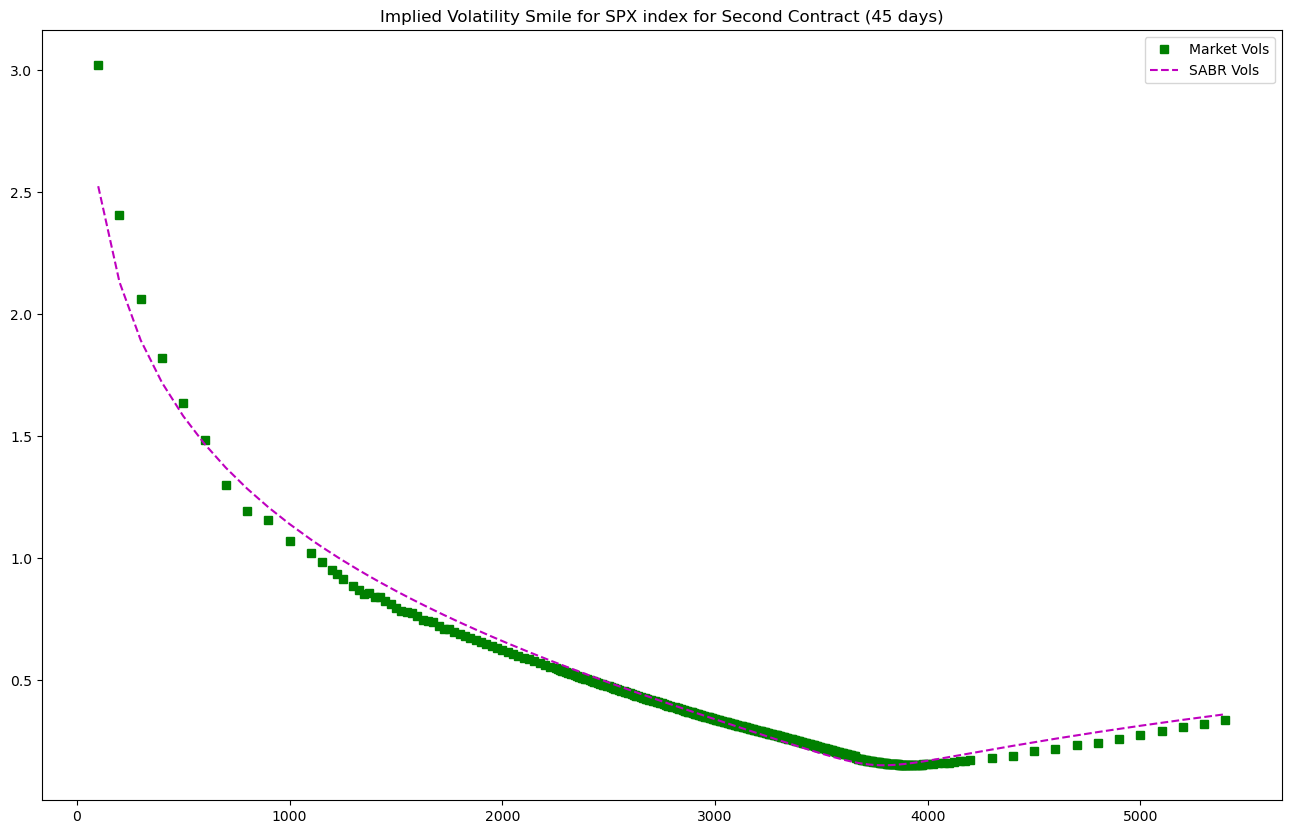

In [69]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spx_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.title("Implied Volatility Smile for SPX index for Second Contract (45 days)")
plt.legend()
plt.show()

In [70]:
rho1 = -0.6
rho2 = 0
rho3 = 0.4

nu1 = 1
nu2 = 3
nu3 = 6

beta = 0.7

In [71]:
summary_SABR = []
for K in strikes:
    impliedvol_SABR = SABR(F, K, T, alpha, beta, rho, nu)
    impliedvol_rho1 = SABR(F, K, T, alpha, beta, rho1, nu)
    impliedvol_rho2 = SABR(F, K, T, alpha, beta, rho2, nu)
    impliedvol_rho3 = SABR(F, K, T, alpha, beta, rho3, nu)
    
    impliedvol_nu1 = SABR(F, K, T, alpha, beta, rho, nu1)
    impliedvol_nu2 = SABR(F, K, T, alpha, beta, rho, nu2)
    impliedvol_nu3 = SABR(F, K, T, alpha, beta, rho, nu3)
    summary_SABR.append([impliedvol_SABR, 
                        impliedvol_rho1, 
                        impliedvol_rho2, 
                        impliedvol_rho3, 
                        impliedvol_nu1, 
                        impliedvol_nu2,
                        impliedvol_nu3])

In [72]:
spx_SABR_df = pd.DataFrame(summary_SABR, 
                          columns = ['impliedvol_SABR', 
                                    'impliedvol_rho1', 
                                    'impliedvol_rho2', 
                                    'impliedvol_rho3', 
                                    'impliedvol_nu1', 
                                    'impliedvol_nu2', 'impliedvol_nu3'])

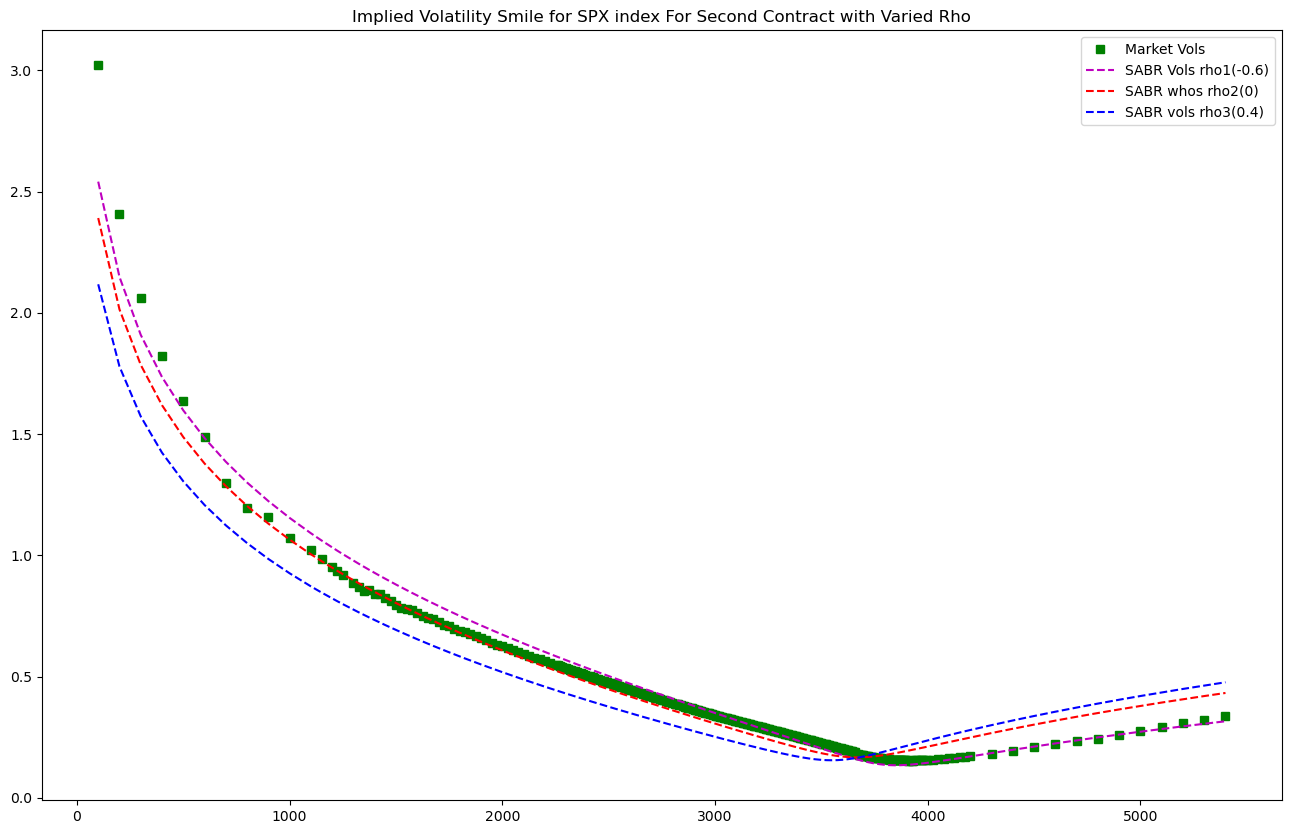

In [73]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spx_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, spx_SABR_df['impliedvol_rho1'], 'm--', label='SABR Vols rho1(-0.6)')
plt.plot(strikes, spx_SABR_df['impliedvol_rho2'], 'r--', label = 'SABR whos rho2(0)')
plt.plot(strikes, spx_SABR_df['impliedvol_rho3'], 'b--', label = 'SABR vols rho3(0.4)')
plt.title("Implied Volatility Smile for SPX index For Second Contract with Varied Rho")
plt.legend()
plt.show()

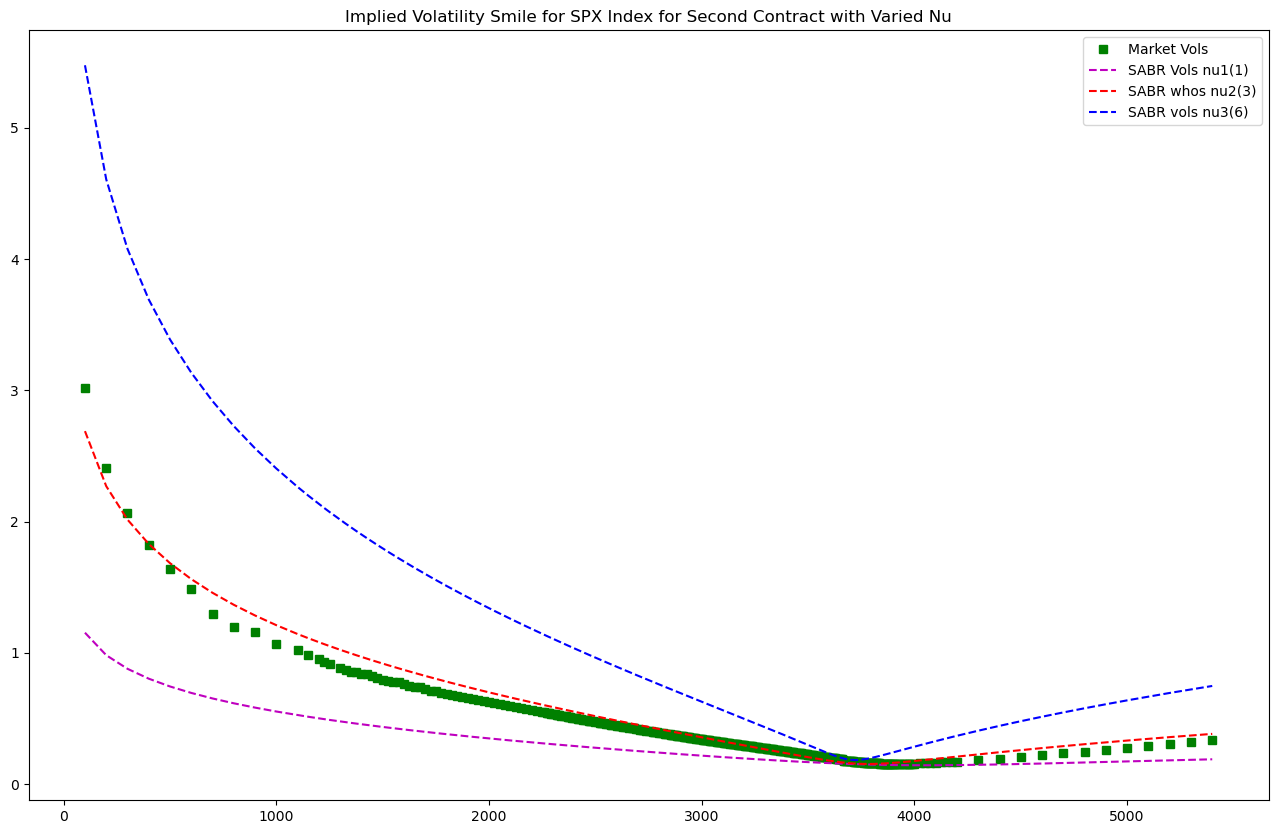

In [74]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spx_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, spx_SABR_df['impliedvol_nu1'], 'm--', label='SABR Vols nu1(1)')
plt.plot(strikes, spx_SABR_df['impliedvol_nu2'], 'r--', label = 'SABR whos nu2(3)')
plt.plot(strikes, spx_SABR_df['impliedvol_nu3'], 'b--', label = 'SABR vols nu3(6)')
plt.title("Implied Volatility Smile for SPX Index for Second Contract with Varied Nu")
plt.legend()
plt.show()

### SABR Model for SPX Index with Third Contract

In [75]:
spx_df = pd.read_csv('SPX_options.csv')
rate_df = pd.read_csv('zero_rates_20201201.csv')
spx_df['mid'] = 0.5*(spx_df['best_bid'] + spx_df['best_offer'])
spx_df['strike'] = spx_df['strike_price']*0.001
spx_df['payoff'] = spx_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(spx_df['exdate'].unique())[2]
spx_df = spx_df[spx_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
y = rate_df['days']
z = rate_df['rate']
f = interpolate.interp1d(y, z)
T = days_to_expiry/365
S = 3662.45
r = f(T * 365)/100.0
F = S*np.exp(r*T)

spx_df['vols'] = spx_df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
spx_df.dropna(inplace=True)
call_df = spx_df[spx_df['payoff'] == 'call']
put_df = spx_df[spx_df['payoff'] == 'put']
strikes = put_df['strike'].values
impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
spx_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              spx_df['strike'],
                                              spx_df['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 2.140, beta = 0.7, rho = -0.575, nu = 1.842


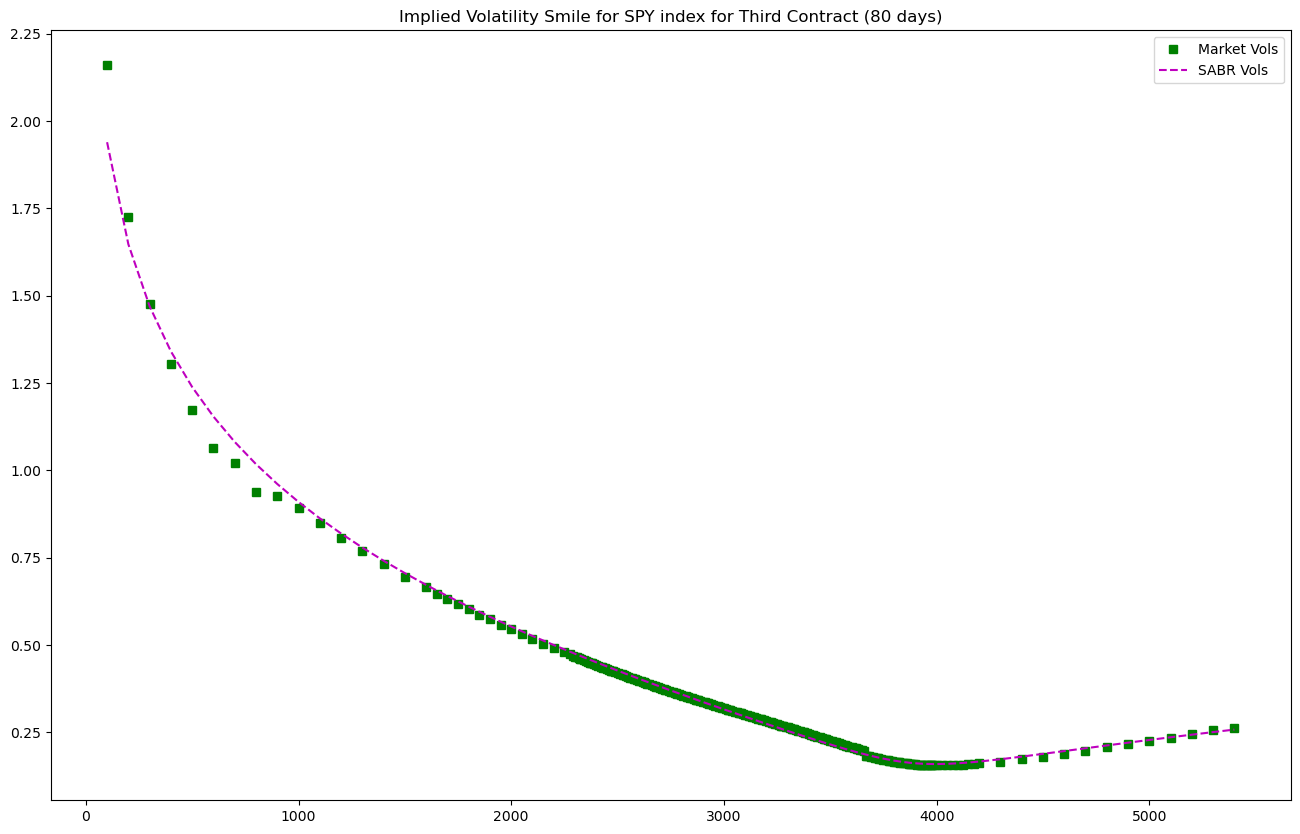

In [82]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spx_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.title("Implied Volatility Smile for SPY index for Third Contract (80 days)")
plt.legend()
plt.show()

In [77]:
rho1 = -0.6
rho2 = 0
rho3 = 0.4

nu1 = 1
nu2 = 2
nu3 = 4

beta = 0.7

In [78]:
summary_SABR = []
for K in strikes:
    impliedvol_SABR = SABR(F, K, T, alpha, beta, rho, nu)
    impliedvol_rho1 = SABR(F, K, T, alpha, beta, rho1, nu)
    impliedvol_rho2 = SABR(F, K, T, alpha, beta, rho2, nu)
    impliedvol_rho3 = SABR(F, K, T, alpha, beta, rho3, nu)
    
    impliedvol_nu1 = SABR(F, K, T, alpha, beta, rho, nu1)
    impliedvol_nu2 = SABR(F, K, T, alpha, beta, rho, nu2)
    impliedvol_nu3 = SABR(F, K, T, alpha, beta, rho, nu3)
    summary_SABR.append([impliedvol_SABR, 
                        impliedvol_rho1, 
                        impliedvol_rho2, 
                        impliedvol_rho3, 
                        impliedvol_nu1, 
                        impliedvol_nu2,
                        impliedvol_nu3])

In [79]:
spx_SABR_df = pd.DataFrame(summary_SABR, 
                          columns = ['impliedvol_SABR', 
                                    'impliedvol_rho1', 
                                    'impliedvol_rho2', 
                                    'impliedvol_rho3', 
                                    'impliedvol_nu1', 
                                    'impliedvol_nu2', 'impliedvol_nu3'])

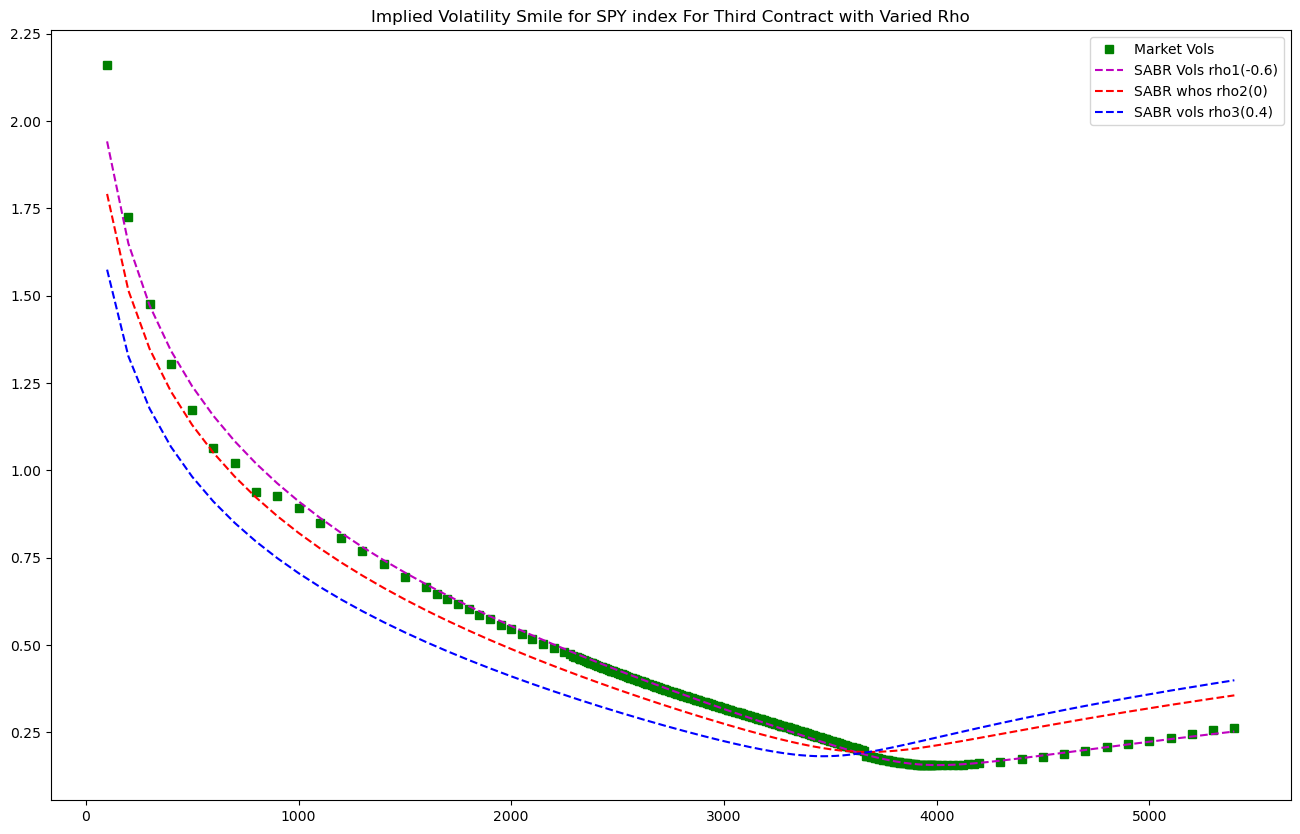

In [80]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spx_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, spx_SABR_df['impliedvol_rho1'], 'm--', label='SABR Vols rho1(-0.6)')
plt.plot(strikes, spx_SABR_df['impliedvol_rho2'], 'r--', label = 'SABR whos rho2(0)')
plt.plot(strikes, spx_SABR_df['impliedvol_rho3'], 'b--', label = 'SABR vols rho3(0.4)')
plt.title("Implied Volatility Smile for SPY index For Third Contract with Varied Rho")
plt.legend()
plt.show()

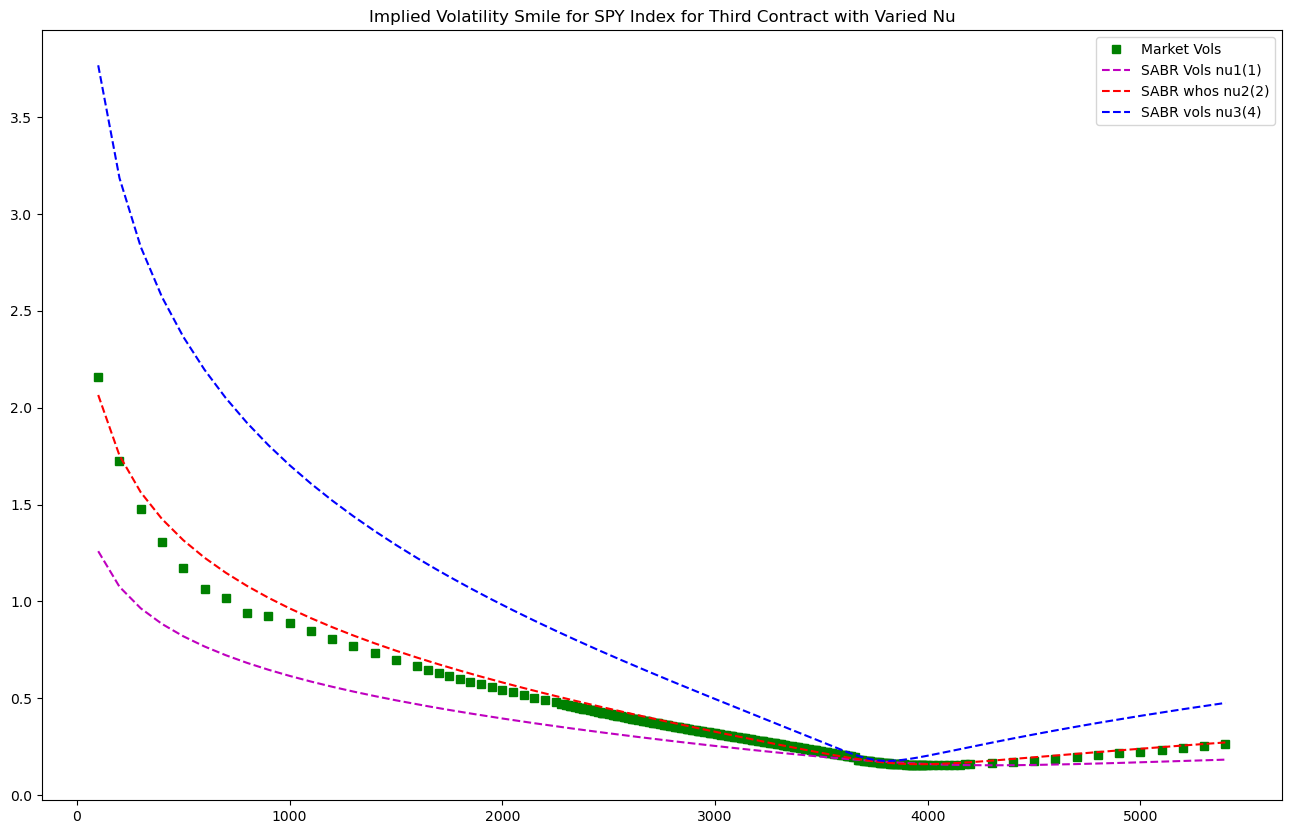

In [81]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spx_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, spx_SABR_df['impliedvol_nu1'], 'm--', label='SABR Vols nu1(1)')
plt.plot(strikes, spx_SABR_df['impliedvol_nu2'], 'r--', label = 'SABR whos nu2(2)')
plt.plot(strikes, spx_SABR_df['impliedvol_nu3'], 'b--', label = 'SABR vols nu3(4)')
plt.title("Implied Volatility Smile for SPY Index for Third Contract with Varied Nu")
plt.legend()
plt.show()

### SABR Model for SPY Index with First Contract

In [83]:
# SABR for SPY index
spy_df = pd.read_csv('SPY_options.csv')
spy_df['mid'] = 0.5*(spy_df['best_bid'] + spy_df['best_offer'])
spy_df['strike'] = spy_df['strike_price']*0.001
spy_df['payoff'] = spy_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(spy_df['exdate'].unique())[0]
spy_df = spy_df[spy_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
y = rate_df['days']
z = rate_df['rate']
f = interpolate.interp1d(y, z)
T = days_to_expiry/365
S = 366.02
r = f(T * 365)/100.0
F = S*np.exp(r*T)

spy_df['vols'] = spy_df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
spy_df.dropna(inplace=True)
call_df = spy_df[spy_df['payoff'] == 'call']
put_df = spy_df[spy_df['payoff'] == 'put']
strikes = put_df['strike'].values
impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
spy_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              spy_df['strike'],
                                              spy_df['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 0.665, beta = 0.7, rho = -0.412, nu = 5.250


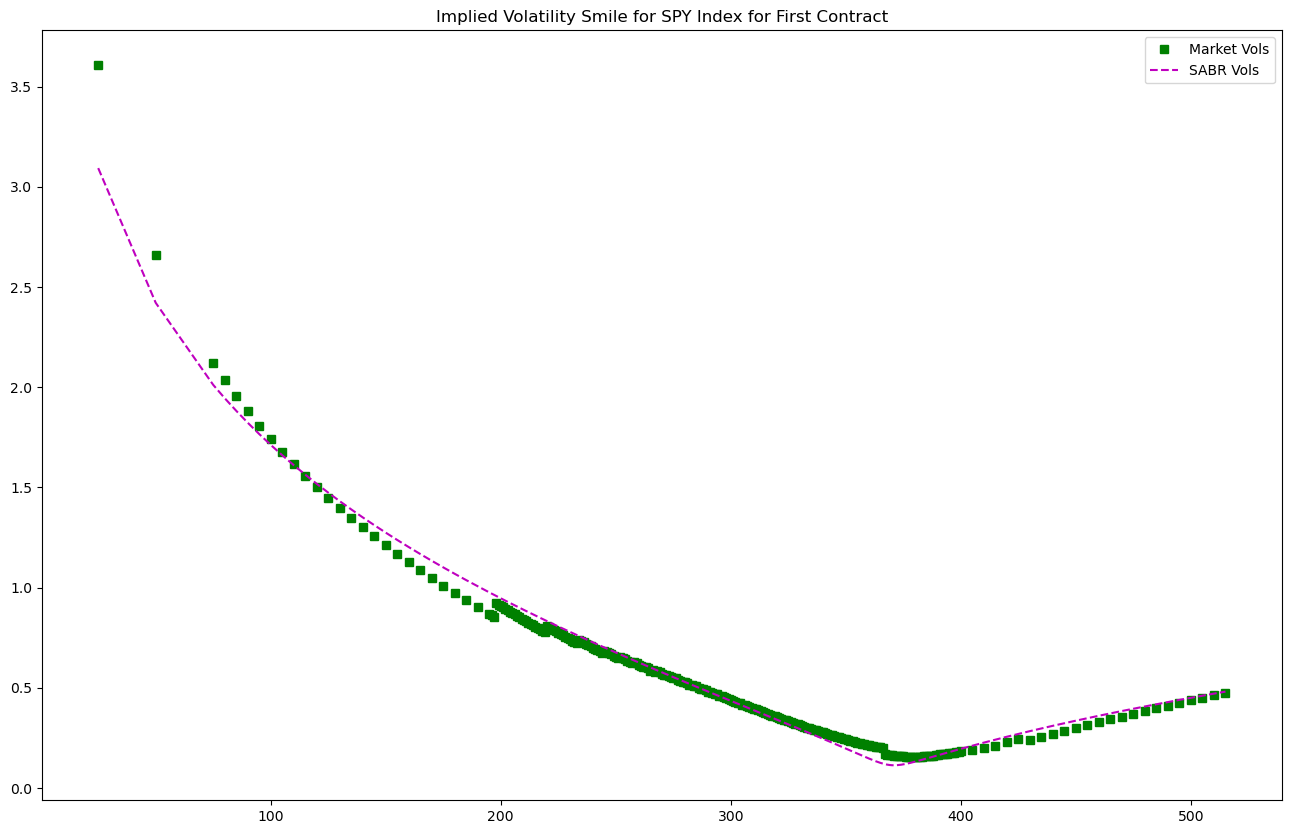

In [84]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spy_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.title("Implied Volatility Smile for SPY Index for First Contract")
plt.legend()
plt.show()

In [85]:
rho1 = -0.6
rho2 = 0
rho3 = 0.4

nu1 = 1
nu2 = 5
nu3 = 10

beta = 0.7

In [ ]:
summary_SABR = []
for K in strikes:
    impliedvol_SABR = SABR(F, K, T, alpha, beta, rho, nu)
    impliedvol_rho1 = SABR(F, K, T, alpha, beta, rho1, nu)
    impliedvol_rho2 = SABR(F, K, T, alpha, beta, rho2, nu)
    impliedvol_rho3 = SABR(F, K, T, alpha, beta, rho3, nu)
    
    impliedvol_nu1 = SABR(F, K, T, alpha, beta, rho, nu1)
    impliedvol_nu2 = SABR(F, K, T, alpha, beta, rho, nu2)
    impliedvol_nu3 = SABR(F, K, T, alpha, beta, rho, nu3)
    summary_SABR.append([impliedvol_SABR, 
                        impliedvol_rho1, 
                        impliedvol_rho2, 
                        impliedvol_rho3, 
                        impliedvol_nu1, 
                        impliedvol_nu2,
                        impliedvol_nu3])

In [ ]:
spy_SABR_df = pd.DataFrame(summary_SABR, 
                          columns = ['impliedvol_SABR', 
                                    'impliedvol_rho1', 
                                    'impliedvol_rho2', 
                                    'impliedvol_rho3', 
                                    'impliedvol_nu1', 
                                    'impliedvol_nu2', 'impliedvol_nu3'])

In [ ]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spy_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, spy_SABR_df['impliedvol_rho1'], 'm--', label='SABR Vols rho1(-0.6)')
plt.plot(strikes, spy_SABR_df['impliedvol_rho2'], 'r--', label = 'SABR whos rho2(0)')
plt.plot(strikes, spy_SABR_df['impliedvol_rho3'], 'b--', label = 'SABR vols rho3(0.4)')
plt.title("Implied Volatility Smile for SPY Index For First Contract with Varied Rho")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spy_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, spy_SABR_df['impliedvol_nu1'], 'm--', label='SABR Vols nu1(1)')
plt.plot(strikes, spy_SABR_df['impliedvol_nu2'], 'r--', label = 'SABR whos nu2(5)')
plt.plot(strikes, spy_SABR_df['impliedvol_nu3'], 'b--', label = 'SABR vols nu3(10)')
plt.title("Implied Volatility Smile for SPY index For First Contract with Varied Nu")
plt.legend()
plt.show()

### SABR Model for SPY Index with Second Contract

In [86]:
# SABR for SPY index
spy_df = pd.read_csv('SPY_options.csv')
spy_df['mid'] = 0.5*(spy_df['best_bid'] + spy_df['best_offer'])
spy_df['strike'] = spy_df['strike_price']*0.001
spy_df['payoff'] = spy_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(spy_df['exdate'].unique())[1]
spy_df = spy_df[spy_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
y = rate_df['days']
z = rate_df['rate']
f = interpolate.interp1d(y, z)
T = days_to_expiry/365
S = 366.02
r = f(T * 365)/100.0
F = S*np.exp(r*T)

spy_df['vols'] = spy_df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
spy_df.dropna(inplace=True)
call_df = spy_df[spy_df['payoff'] == 'call']
put_df = spy_df[spy_df['payoff'] == 'put']
strikes = put_df['strike'].values
impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
spy_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              spy_df['strike'],
                                              spy_df['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 0.908, beta = 0.7, rho = -0.489, nu = 2.729


In [ ]:
plt.figure(tight_layout=True)
plt.plot(strikes, spy_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.title("Implied Volatility Smile for SPY Index for Second Contract")
plt.legend()
plt.show()

In [ ]:
rho1 = -0.6
rho2 = 0
rho3 = 0.4

nu1 = 1
nu2 = 3
nu3 = 6

beta = 0.7

In [ ]:
summary_SABR = []
for K in strikes:
    impliedvol_SABR = SABR(F, K, T, alpha, beta, rho, nu)
    impliedvol_rho1 = SABR(F, K, T, alpha, beta, rho1, nu)
    impliedvol_rho2 = SABR(F, K, T, alpha, beta, rho2, nu)
    impliedvol_rho3 = SABR(F, K, T, alpha, beta, rho3, nu)
    
    impliedvol_nu1 = SABR(F, K, T, alpha, beta, rho, nu1)
    impliedvol_nu2 = SABR(F, K, T, alpha, beta, rho, nu2)
    impliedvol_nu3 = SABR(F, K, T, alpha, beta, rho, nu3)
    summary_SABR.append([impliedvol_SABR, 
                        impliedvol_rho1, 
                        impliedvol_rho2, 
                        impliedvol_rho3, 
                        impliedvol_nu1, 
                        impliedvol_nu2,
                        impliedvol_nu3])

In [ ]:
spy_SABR_df = pd.DataFrame(summary_SABR, 
                          columns = ['impliedvol_SABR', 
                                    'impliedvol_rho1', 
                                    'impliedvol_rho2', 
                                    'impliedvol_rho3', 
                                    'impliedvol_nu1', 
                                    'impliedvol_nu2', 'impliedvol_nu3'])

In [ ]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spy_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, spy_SABR_df['impliedvol_rho1'], 'm--', label='SABR Vols rho1(-0.6)')
plt.plot(strikes, spy_SABR_df['impliedvol_rho2'], 'r--', label = 'SABR whos rho2(0)')
plt.plot(strikes, spy_SABR_df['impliedvol_rho3'], 'b--', label = 'SABR vols rho3(0.4)')
plt.title("Implied Volatility Smile for SPY Index For First Contract with Varied Rho")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spy_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, spy_SABR_df['impliedvol_nu1'], 'm--', label='SABR Vols nu1(1)')
plt.plot(strikes, spy_SABR_df['impliedvol_nu2'], 'r--', label = 'SABR whos nu2(5)')
plt.plot(strikes, spy_SABR_df['impliedvol_nu3'], 'b--', label = 'SABR vols nu3(10)')
plt.title("Implied Volatility Smile for SPY index For First Contract with Varied Nu")
plt.legend()
plt.show()

### SABR Model for SPY Index with Third Contract

In [87]:
# SABR for SPY index
spy_df = pd.read_csv('SPY_options.csv')
spy_df['mid'] = 0.5*(spy_df['best_bid'] + spy_df['best_offer'])
spy_df['strike'] = spy_df['strike_price']*0.001
spy_df['payoff'] = spy_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(spy_df['exdate'].unique())[2]
spy_df = spy_df[spy_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
y = rate_df['days']
z = rate_df['rate']
f = interpolate.interp1d(y, z)
T = days_to_expiry/365
S = 366.02
r = f(T * 365)/100.0
F = S*np.exp(r*T)

spy_df['vols'] = spy_df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
spy_df.dropna(inplace=True)
call_df = spy_df[spy_df['payoff'] == 'call']
put_df = spy_df[spy_df['payoff'] == 'put']
strikes = put_df['strike'].values
impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
spy_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              spy_df['strike'],
                                              spy_df['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 1.121, beta = 0.7, rho = -0.633, nu = 1.742


In [ ]:
plt.figure(tight_layout=True)
plt.plot(strikes, spy_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.title("Implied Volatility Smile for SPY Index for Second Contract")
plt.legend()
plt.show()

In [ ]:
rho1 = -0.6
rho2 = 0
rho3 = 0.4

nu1 = 1
nu2 = 2
nu3 = 4

beta = 0.7

In [ ]:
summary_SABR = []
for K in strikes:
    impliedvol_SABR = SABR(F, K, T, alpha, beta, rho, nu)
    impliedvol_rho1 = SABR(F, K, T, alpha, beta, rho1, nu)
    impliedvol_rho2 = SABR(F, K, T, alpha, beta, rho2, nu)
    impliedvol_rho3 = SABR(F, K, T, alpha, beta, rho3, nu)
    
    impliedvol_nu1 = SABR(F, K, T, alpha, beta, rho, nu1)
    impliedvol_nu2 = SABR(F, K, T, alpha, beta, rho, nu2)
    impliedvol_nu3 = SABR(F, K, T, alpha, beta, rho, nu3)
    summary_SABR.append([impliedvol_SABR, 
                        impliedvol_rho1, 
                        impliedvol_rho2, 
                        impliedvol_rho3, 
                        impliedvol_nu1, 
                        impliedvol_nu2,
                        impliedvol_nu3])

In [ ]:
spy_SABR_df = pd.DataFrame(summary_SABR, 
                          columns = ['impliedvol_SABR', 
                                    'impliedvol_rho1', 
                                    'impliedvol_rho2', 
                                    'impliedvol_rho3', 
                                    'impliedvol_nu1', 
                                    'impliedvol_nu2', 'impliedvol_nu3'])

In [ ]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spy_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, spy_SABR_df['impliedvol_rho1'], 'm--', label='SABR Vols rho1(-0.6)')
plt.plot(strikes, spy_SABR_df['impliedvol_rho2'], 'r--', label = 'SABR whos rho2(0)')
plt.plot(strikes, spy_SABR_df['impliedvol_rho3'], 'b--', label = 'SABR vols rho3(0.4)')
plt.title("Implied Volatility Smile for SPY Index For First Contract with Varied Rho")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (16, 10))
plt.plot(strikes, spy_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, spy_SABR_df['impliedvol_nu1'], 'm--', label='SABR Vols nu1(1)')
plt.plot(strikes, spy_SABR_df['impliedvol_nu2'], 'r--', label = 'SABR whos nu2(5)')
plt.plot(strikes, spy_SABR_df['impliedvol_nu3'], 'b--', label = 'SABR vols nu3(10)')
plt.title("Implied Volatility Smile for SPY index For First Contract with Varied Nu")
plt.legend()
plt.show()